# SC Cosmetics 

## Import Libaries

In [2]:
!pip install pyathena
!pip install imbalanced-learn
!pip install -q smclarify==0.1
!pip install --upgrade statsmodels
!pip install --upgrade threadpoolctl

import boto3
import sagemaker

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyathena import connect
from imblearn.over_sampling import SMOTE

from smclarify.bias import report
from typing import Dict
from collections import defaultdict

from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split


%matplotlib inline
%config InlineBackend.figure_format='retina'

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run su

## Copy Data from S3
https://sc-cosmetics-data.s3.amazonaws.com/chemicals-in-cosmetics/cosmetic_chemicals.csv

https://sc-cosmetics-data.s3.amazonaws.com/cosmetic-ingedients-ranking-pricing/cosmetics.csv

https://sc-cosmetics-data.s3.amazonaws.com/customer-propensity-to-purchase/customer.csv

In [3]:
# define the S3 bucket, role, and region
sess = sagemaker.Session()
bucket = "sc-cosmetics-data"  
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# define S3 paths for the source (public) and destination (private) locations
s3_public_path_chemicals = "s3://sc-cosmetics-data/chemicals-in-cosmetics"
s3_public_path_cosmetics = "s3://sc-cosmetics-data/cosmetic-ingredients-ranking-pricing"
s3_public_path_customer = "s3://sc-cosmetics-data/customer-propensity-to-purchase"
s3_private_path = f"s3://{bucket}/"  
s3_private_path_chemicals = f"s3://{bucket}/chemicals-in-cosmetics"
s3_private_path_cosmetics = f"s3://{bucket}/cosmetic-ingredients-ranking-pricing"
s3_private_path_customer = f"s3://{bucket}/customer-propensity-to-purchase"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
# copy data from the public S3 buckets to our private S3 buckets
!aws s3 cp --recursive $s3_public_path_chemicals/ $s3_private_path_chemicals/
!aws s3 cp --recursive $s3_public_path_cosmetics/ $s3_private_path_cosmetics/
!aws s3 cp --recursive $s3_public_path_customer/ $s3_private_path_customer/

copy: s3://sc-cosmetics-data/chemicals-in-cosmetics/cosmetic_chemicals.csv to s3://sc-cosmetics-data/chemicals-in-cosmetics/cosmetic_chemicals.csv
copy: s3://sc-cosmetics-data/cosmetic-ingredients-ranking-pricing/cosmetics.csv to s3://sc-cosmetics-data/cosmetic-ingredients-ranking-pricing/cosmetics.csv
copy: s3://sc-cosmetics-data/customer-propensity-to-purchase/customer.csv to s3://sc-cosmetics-data/customer-propensity-to-purchase/customer.csv


In [5]:
# list files in private S3 bucket
print("Files in private S3 bucket - Chemicals:")
!aws s3 ls $s3_private_path_chemicals/

print("\nFiles in private S3 bucket - Cosmetics:")
!aws s3 ls $s3_private_path_cosmetics/

print("\nFiles in private S3 bucket - Customer:")
!aws s3 ls $s3_private_path_customer/

Files in private S3 bucket - Chemicals:
2024-03-30 21:20:45   23962866 cosmetic_chemicals.csv

Files in private S3 bucket - Cosmetics:
2024-03-30 21:20:47    1157561 cosmetics.csv

Files in private S3 bucket - Customer:
2024-03-30 21:20:48   35077633 customer.csv


In [6]:
# read files into pd df
chemicals_df = pd.read_csv(s3_private_path_chemicals + "/cosmetic_chemicals.csv")
cosmetics_df = pd.read_csv(s3_private_path_cosmetics + "/cosmetics.csv")
customer_df = pd.read_csv(s3_private_path_customer + "/customer.csv")

## Data Exploration

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
chemicals_df.head()

,ProductName,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,SubCategory,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalCount,Discontinued,ChemicalRemoved,brand_id
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,Lip Color - Lipsticks Liners and Pencils,6,Titanium dioxide,2009-06-17,2013-08-28,2009-07-09,2009-07-09,1,1,0,82
1,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),4,Distillates (coal tar),2009-07-01,2009-07-01,2009-07-01,2009-07-01,2,0,0,1023
2,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),5,Estragole,2009-07-01,2009-07-01,2009-07-02,2009-07-02,2,0,0,1023
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,Eyeliner/Eyebrow Pencils,7,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,0,0,82
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,Lip Gloss/Shine,8,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,1,0,82


In [9]:
chemicals_df['PrimaryCategory'].value_counts() 

Makeup Products (non-permanent)      75827
Nail Products                        15347
Skin Care Products                    7683
Sun-Related Products                  4939
Bath Products                         3466
Hair Coloring Products                2061
Hair Care Products (non-coloring)     1620
Tattoos and Permanent Makeup          1477
Personal Care Products                 765
Fragrances                             654
Oral Hygiene Products                  525
Shaving Products                       222
Baby Products                           49
Name: PrimaryCategory, dtype: int64

In [10]:
cosmetics_df.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,brand_id,product_id
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Algae (Seaweed) Extract- Mineral Oil- Petrolat...,1,1,1,1,1,64,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,Galactomyces Ferment Filtrate (Pitera)- Butyle...,1,1,1,1,1,95,2
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,Water- Dicaprylyl Carbonate- Glycerin- Ceteary...,1,1,1,1,0,29,3
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,Algae (Seaweed) Extract- Cyclopentasiloxane- P...,1,1,1,1,1,64,4
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,Water- Snail Secretion Filtrate- Phenyl Trimet...,1,1,1,1,1,49,5


In [11]:
cosmetics_df['Label'].value_counts()

Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: Label, dtype: int64

In [12]:
customer_df.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,account_page_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,product_id
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,NaN
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,NaN
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,766.0


Since the cosmetics dataframe exclusively comprises skincare items, our analysis will focus solely on skincare products and those associated with sun protection from the chemicals present in the cosmetic dataframe.

## Table Manipulation

### chemicals table

### cosmetics table

### customer table

## Create Athena Database

In [13]:
# athena database name
db_name = 'sc_cosmetics'

In [14]:
# S3 staging directory
s3_staging = "s3://{0}/athena/staging".format(bucket)

In [15]:
# create connection for athena database
conn = connect(region_name=region, s3_staging_dir=s3_staging)

In [16]:
create_query = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)
pd.read_sql(create_query, conn)

""


In [17]:
# create chemicals in cosmetics table
chem_table_name ='cosmetic_chemicals'

# chemical data S3 directory
chem_s3_dir = f's3://{bucket}/chemicals-in-cosmetics'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{chem_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{chem_table_name}(
                ProductName string,
                CompanyID int,
                CompanyName string,
                BrandName string,
                PrimaryCategoryID int,
                PrimaryCategory string,
                SubCategoryID int,
                SubCategory string,
                ChemicalID int,
                ChemicalName string,
                InitialDateReported date,
                MostRecentDateReported date,
                ChemicalCreatedAt date,
                ChemicalUpdatedAt date,
                ChemicalCount int,
                Discontinued int,
                ChemicalRemoved int, 
                brand_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{chem_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [18]:
# view top 5 rows of chemical_cosmetics table
pd.read_sql(f'SELECT * FROM {db_name}.{chem_table_name} LIMIT 5', conn)

,productname,companyid,companyname,brandname,primarycategoryid,primarycategory,subcategoryid,subcategory,chemicalid,chemicalname,initialdatereported,mostrecentdatereported,chemicalcreatedat,chemicalupdatedat,chemicalcount,discontinued,chemicalremoved,brand_id
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,Lip Color - Lipsticks Liners and Pencils,6,Titanium dioxide,2009-06-17,2013-08-28,2009-07-09,2009-07-09,1,1,0,82
1,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),4,Distillates (coal tar),2009-07-01,2009-07-01,2009-07-01,2009-07-01,2,0,0,1023
2,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),5,Estragole,2009-07-01,2009-07-01,2009-07-02,2009-07-02,2,0,0,1023
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,Eyeliner/Eyebrow Pencils,7,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,0,0,82
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,Lip Gloss/Shine,8,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,1,0,82


In [19]:
# create subquery with the skin care products and sun-related products 

skinproducts_sub = ["Sun-Related Products", "Skin Care Products "]
in_clause = "', '".join(skinproducts_sub)

sub_query = f"""
            (
            SELECT *
            FROM sc_cosmetics.cosmetic_chemicals
            WHERE PrimaryCategory IN ('{in_clause}')
            )
"""

# create a new table using the subquery
cosmetic_chemicals_sub = f"""
                         CREATE TABLE IF NOT EXISTS {db_name}.cosmetic_chemicals_sub AS {sub_query}
                         """

# Execute the create table query
with conn.cursor() as cursor:
    cursor.execute(cosmetic_chemicals_sub)

In [20]:
# create cosmetics table
cos_table_name ='cosmetics'

# cosmetics data S3 directory
cos_s3_dir = f's3://{bucket}/cosmetic-ingredients-ranking-pricing'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{cos_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{cos_table_name}(
                Label string,
                Brand string,
                Name string,
                Price float,
                Rank float,
                Ingredients string,
                Combination int,
                Dry int,
                Normal int,
                Oily int,
                Sensitive int,
                product_id int, 
                brand_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{cos_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [21]:
# view top 5 rows of cosmetics table
pd.read_sql(f'SELECT * FROM {db_name}.{cos_table_name} LIMIT 5', conn)

,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id
0,Moisturizer,LA MER,Crème de la Mer,175.0,4.1,Algae (Seaweed) Extract- Mineral Oil- Petrolat...,1,1,1,1,1,64,1
1,Moisturizer,SK-II,Facial Treatment Essence,179.0,4.1,Galactomyces Ferment Filtrate (Pitera)- Butyle...,1,1,1,1,1,95,2
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68.0,4.4,Water- Dicaprylyl Carbonate- Glycerin- Ceteary...,1,1,1,1,0,29,3
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175.0,3.8,Algae (Seaweed) Extract- Cyclopentasiloxane- P...,1,1,1,1,1,64,4
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38.0,4.1,Water- Snail Secretion Filtrate- Phenyl Trimet...,1,1,1,1,1,49,5


In [22]:
# create customer table
cust_table_name ='customer'

# customer data S3 directory
cust_s3_dir = f's3://{bucket}/customer-propensity-to-purchase'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{cust_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{cust_table_name}(
                UserID string,
                basket_icon_click int,
                basket_add_list int,
                basket_add_detail int,
                sort_by int,
                account_page_click int,
                detail_wishlist_add int,
                list_size_dropdown int,
                closed_minibasket_click int,
                checked_delivery_detail int,
                checked_returns_detail int,
                sign_in int,
                saw_checkout int,
                saw_delivery int,
                saw_homepage int,
                device_mobile int,
                device_computer int,
                device_tablet int,
                returning_user int,
                loc_uk int,
                ordered int,
                product_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{cust_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [23]:
# view top 5 rows of customer table
pd.read_sql(f'SELECT * FROM {db_name}.{cust_table_name} LIMIT 5', conn)

,userid,basket_icon_click,basket_add_list,basket_add_detail,sort_by,account_page_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,product_id
0,84d0-82c61917-84d0-41aa-a04c-607845,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,None
1,68dc-82c6b1c9-68dc-b168-8425-91412,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,None
2,8786-82c1eb1b-8786-411b-bd14-548509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,None
3,1a2b-82c6b429-1a2b-4c1d-b019-845548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,None
4,c752-82c6b546-c752-47a3-a5bd-104606,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,None


In [24]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,sagemaker_featurestore
3,sc_cosmetics


In [25]:
# define query to show tables in db
show_tables_query = f"SHOW TABLES IN {db_name}"

# execute query+ display tables in db
tables_df = pd.read_sql(show_tables_query, conn)
tables_df

,tab_name
0,cosmetic_chemicals
1,cosmetic_chemicals_sub
2,cosmetics
3,customer
4,sc_cosmetics_app
5,skin_products


In [26]:
if db_name in df_show.values:
    ingest_create_athena_db_passed = True

In [27]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [28]:
# define SQL query
query = """
        SELECT cu.UserID,
               cu.basket_icon_click,
               cu.basket_add_list,
               cu.account_page_click,
               cu.detail_wishlist_add,
               cu.saw_checkout,
               cu.device_mobile,
               cu.device_computer, 
               cu.device_tablet,
               cu.returning_user,
               cu.ordered,
               c.*,
               ccc.PrimaryCategory,
               ccc.SubCategory,
               ccc.ChemicalName,
               ccc.ChemicalCount,
               ccc.Discontinued,
               ccc.ChemicalRemoved
        FROM sc_cosmetics.customer cu
        INNER JOIN sc_cosmetics.cosmetics c ON cu.product_id = c.product_id
        INNER JOIN sc_cosmetics.cosmetic_chemicals_sub ccc ON c.brand_id = ccc.brand_id;
        """

In [29]:
sc_df = pd.read_sql(query, conn)

In [30]:
sc_df.sample(n=10, random_state=42)

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
31078,c7d7-ac1e8977-c7d7-4db0-a657-307042,1,0,0,0,1,1,0,0,1,1,Moisturizer,AMOREPACIFIC,FUTURE RESPONSE Age Defense Creme,195.0,4.4,Camellia Sinensis Leaf Water- Butylene Glycol-...,1,1.0,1,1,1,1,79,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
44152,065c-1c33b077-065c-4382-b179-268024,1,0,0,0,1,1,0,0,1,1,Moisturizer,LANCÔME,Rénergie Lift Multi-Action Sunscreen Broad Spe...,99.0,3.9,Water- Dimethicone- Glycerin- Hydrogenated Pol...,1,1.0,1,1,1,66,249,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,2.0,0.0,0.0
43248,7765-29ab1200-7765-498d-8763-888156,1,0,0,0,1,0,1,0,1,1,Moisturizer,PETER THOMAS ROTH,Water Drench Hyaluronic Cloud Cream,52.0,4.4,Water- Glycerin- Cyclopentasiloxane- Dipropyle...,1,1.0,1,1,1,87,82,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
20957,5642-c776771a-5642-4976-ab38-433170,1,1,0,0,1,0,0,1,1,1,Cleanser,CAUDALIE,Vinopure Natural Salicylic Acid Pore Minimizin...,28.0,3.8,*Plant origin.,1,0.0,1,1,1,15,352,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
17552,cadb-546776b3-cadb-4130-8423-697980,0,0,0,0,1,0,1,0,1,1,Treatment,ESTÉE LAUDER,Idealist Pore Minimizing Skin Refinisher,86.0,4.0,Idealist Extra Pore Min Skin Refin Division: E...,0,0.0,0,0,0,33,695,Skin Care Products,Skin Bleaching (making a cosmetic claim),Triethanolamine,2.0,0.0,0.0
28868,9750-b2536806-9750-4c60-ad50-54987,1,1,0,0,1,0,0,1,1,1,Sun protect,CLINIQUE,Superdefense SPF 20 Age Defense Moisturizer Co...,48.0,4.0,Avobenzone 3.00% - Octisalate 5.00%Water - But...,0,0.0,0,0,0,19,1371,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
43145,3737-2910c2c3-3737-4671-8557-94608,1,1,0,0,1,0,0,1,1,1,Moisturizer,LANCÔME,Rénergie Lift Multi-Action Sunscreen Broad Spe...,99.0,3.9,Water- Dimethicone- Glycerin- Hydrogenated Pol...,1,1.0,1,1,1,66,249,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,2.0,0.0,0.0
24128,24d5-52d35806-24d5-4617-9741-487056,0,0,0,0,1,0,1,0,0,1,Sun protect,LAURA MERCIER,Tinted Moisturizer Broad Spectrum SPF 20 - Oil...,45.0,4.3,Visit the Laura Mercier boutique,0,0.0,0,0,0,68,1304,Skin Care Products,Facial Cream,Oil Orange SS,1.0,0.0,0.0
41738,6b1e-31299825-6b1e-4877-920b-473374,1,1,0,0,1,1,0,0,1,1,Face Mask,BLITHE,Soothing & Healing Green Tea Splash Mask,45.0,4.6,Water- Lactic Acid- Vaccinium Myrtillus Fruit ...,1,0.0,1,1,0,11,985,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
17523,cadb-546776b3-cadb-4130-8423-697980,0,0,0,0,1,0,1,0,1,1,Face Mask,ESTÉE LAUDER,NightWear Plus 3-Minute Detox Mask,47.0,4.6,Nightwear Detox Mask Division: El (Estee Laude...,0,0.0,0,0,0,33,1014,Skin Care Products,Facial Masks,Titanium dioxide,1.0,0.0,0.0


## Exploratory Data Analysis (EDA)

In [31]:
# inspect df 
print('Number of Rows:', sc_df.shape[0])
print('Number of Columns:', sc_df.shape[1], '\n')

sc_df.info()

Number of Rows: 53325
Number of Columns: 30 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53325 entries, 0 to 53324
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               53325 non-null  object 
 1   basket_icon_click    53325 non-null  int64  
 2   basket_add_list      53325 non-null  int64  
 3   account_page_click   53325 non-null  int64  
 4   detail_wishlist_add  53325 non-null  int64  
 5   saw_checkout         53325 non-null  int64  
 6   device_mobile        53325 non-null  int64  
 7   device_computer      53325 non-null  int64  
 8   device_tablet        53325 non-null  int64  
 9   returning_user       53325 non-null  int64  
 10  ordered              53325 non-null  int64  
 11  label                53325 non-null  object 
 12  brand                53325 non-null  object 
 13  name                 53325 non-null  object 
 14  price                53085 non-null  flo

### Identifying and Removing Null Values

In [32]:
sc_df.isnull().sum()

UserID                   0
basket_icon_click        0
basket_add_list          0
account_page_click       0
detail_wishlist_add      0
saw_checkout             0
device_mobile            0
device_computer          0
device_tablet            0
returning_user           0
ordered                  0
label                    0
brand                    0
name                     0
price                  240
rank                   240
ingredients              0
combination              0
dry                    240
normal                   0
oily                     0
sensitive                0
product_id               0
brand_id                 0
PrimaryCategory          0
SubCategory              0
ChemicalName             0
ChemicalCount          504
Discontinued            24
ChemicalRemoved         24
dtype: int64

In [33]:
# calculate missing values as a percentage of total data 
missing_percentage = (sc_df.isnull().sum() / len(sc_df)) * 100 # convert to percentage 
missing_percentage = missing_percentage.sort_values(ascending=False) # place in ascending order

print('Missing Value Percentage per Column:')
print(missing_percentage)

Missing Value Percentage per Column:
ChemicalCount          0.945148
rank                   0.450070
price                  0.450070
dry                    0.450070
Discontinued           0.045007
ChemicalRemoved        0.045007
device_mobile          0.000000
device_computer        0.000000
basket_add_list        0.000000
account_page_click     0.000000
ChemicalName           0.000000
SubCategory            0.000000
PrimaryCategory        0.000000
brand_id               0.000000
product_id             0.000000
sensitive              0.000000
oily                   0.000000
normal                 0.000000
detail_wishlist_add    0.000000
combination            0.000000
ingredients            0.000000
basket_icon_click      0.000000
saw_checkout           0.000000
name                   0.000000
brand                  0.000000
label                  0.000000
ordered                0.000000
returning_user         0.000000
device_tablet          0.000000
UserID                 0.000000
dty

In [34]:
# impute values with rows missing less than 20% data using mode 
low_missing_cols = ['ChemicalCount', 'price', 'rank', 'dry','ChemicalRemoved', 'Discontinued']
for col in low_missing_cols:
    sc_df[col] = sc_df[col].fillna(sc_df[col].mode()[0])

In [35]:
sc_df.isnull().sum() # confrim misisng values are handles 

UserID                 0
basket_icon_click      0
basket_add_list        0
account_page_click     0
detail_wishlist_add    0
saw_checkout           0
device_mobile          0
device_computer        0
device_tablet          0
returning_user         0
ordered                0
label                  0
brand                  0
name                   0
price                  0
rank                   0
ingredients            0
combination            0
dry                    0
normal                 0
oily                   0
sensitive              0
product_id             0
brand_id               0
PrimaryCategory        0
SubCategory            0
ChemicalName           0
ChemicalCount          0
Discontinued           0
ChemicalRemoved        0
dtype: int64

In [36]:
sc_df.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
0,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1.0,1,1,1,97,1420,Skin Care Products,Facial Masks,Titanium dioxide,1.0,0.0,0.0
1,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1.0,1,1,1,97,1420,Skin Care Products,Skin Cleansers,Titanium dioxide,1.0,0.0,0.0
2,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1.0,1,1,1,97,1420,Skin Care Products,Facial Cream,Titanium dioxide,1.0,0.0,0.0
3,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1.0,1,1,1,97,1420,Skin Care Products,Facial Cream,Titanium dioxide,1.0,0.0,0.0
4,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1.0,1,1,1,97,1420,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0


In [37]:
sc_df['ChemicalName'].value_counts() # Chemicals present in cosmetics 

Titanium dioxide                       43681
Triethanolamine                         1947
Vitamin A palmitate                      834
Butylated hydroxyanisole                 819
Retinyl palmitate                        794
Coffea arabica extract                   708
Retinol                                  635
Trade Secret                             592
Mica                                     283
"Titanium dioxide (airborne              280
Caffeine                                 248
Estragole                                244
Cocamide diethanolamine                  243
Coffee                                   197
Oil Orange SS                            186
Methyleugenol                            185
Ginkgo biloba extract                    175
Cosmetic talc                            132
beta-Myrcene                             127
Avobenzone                               108
"Silica                                  100
"Mineral oils                             80
Toluene   

In [38]:
sc_df.shape #30 columns and 53325 rows of data 

(53325, 30)

### Visualizations 

#### Histograms

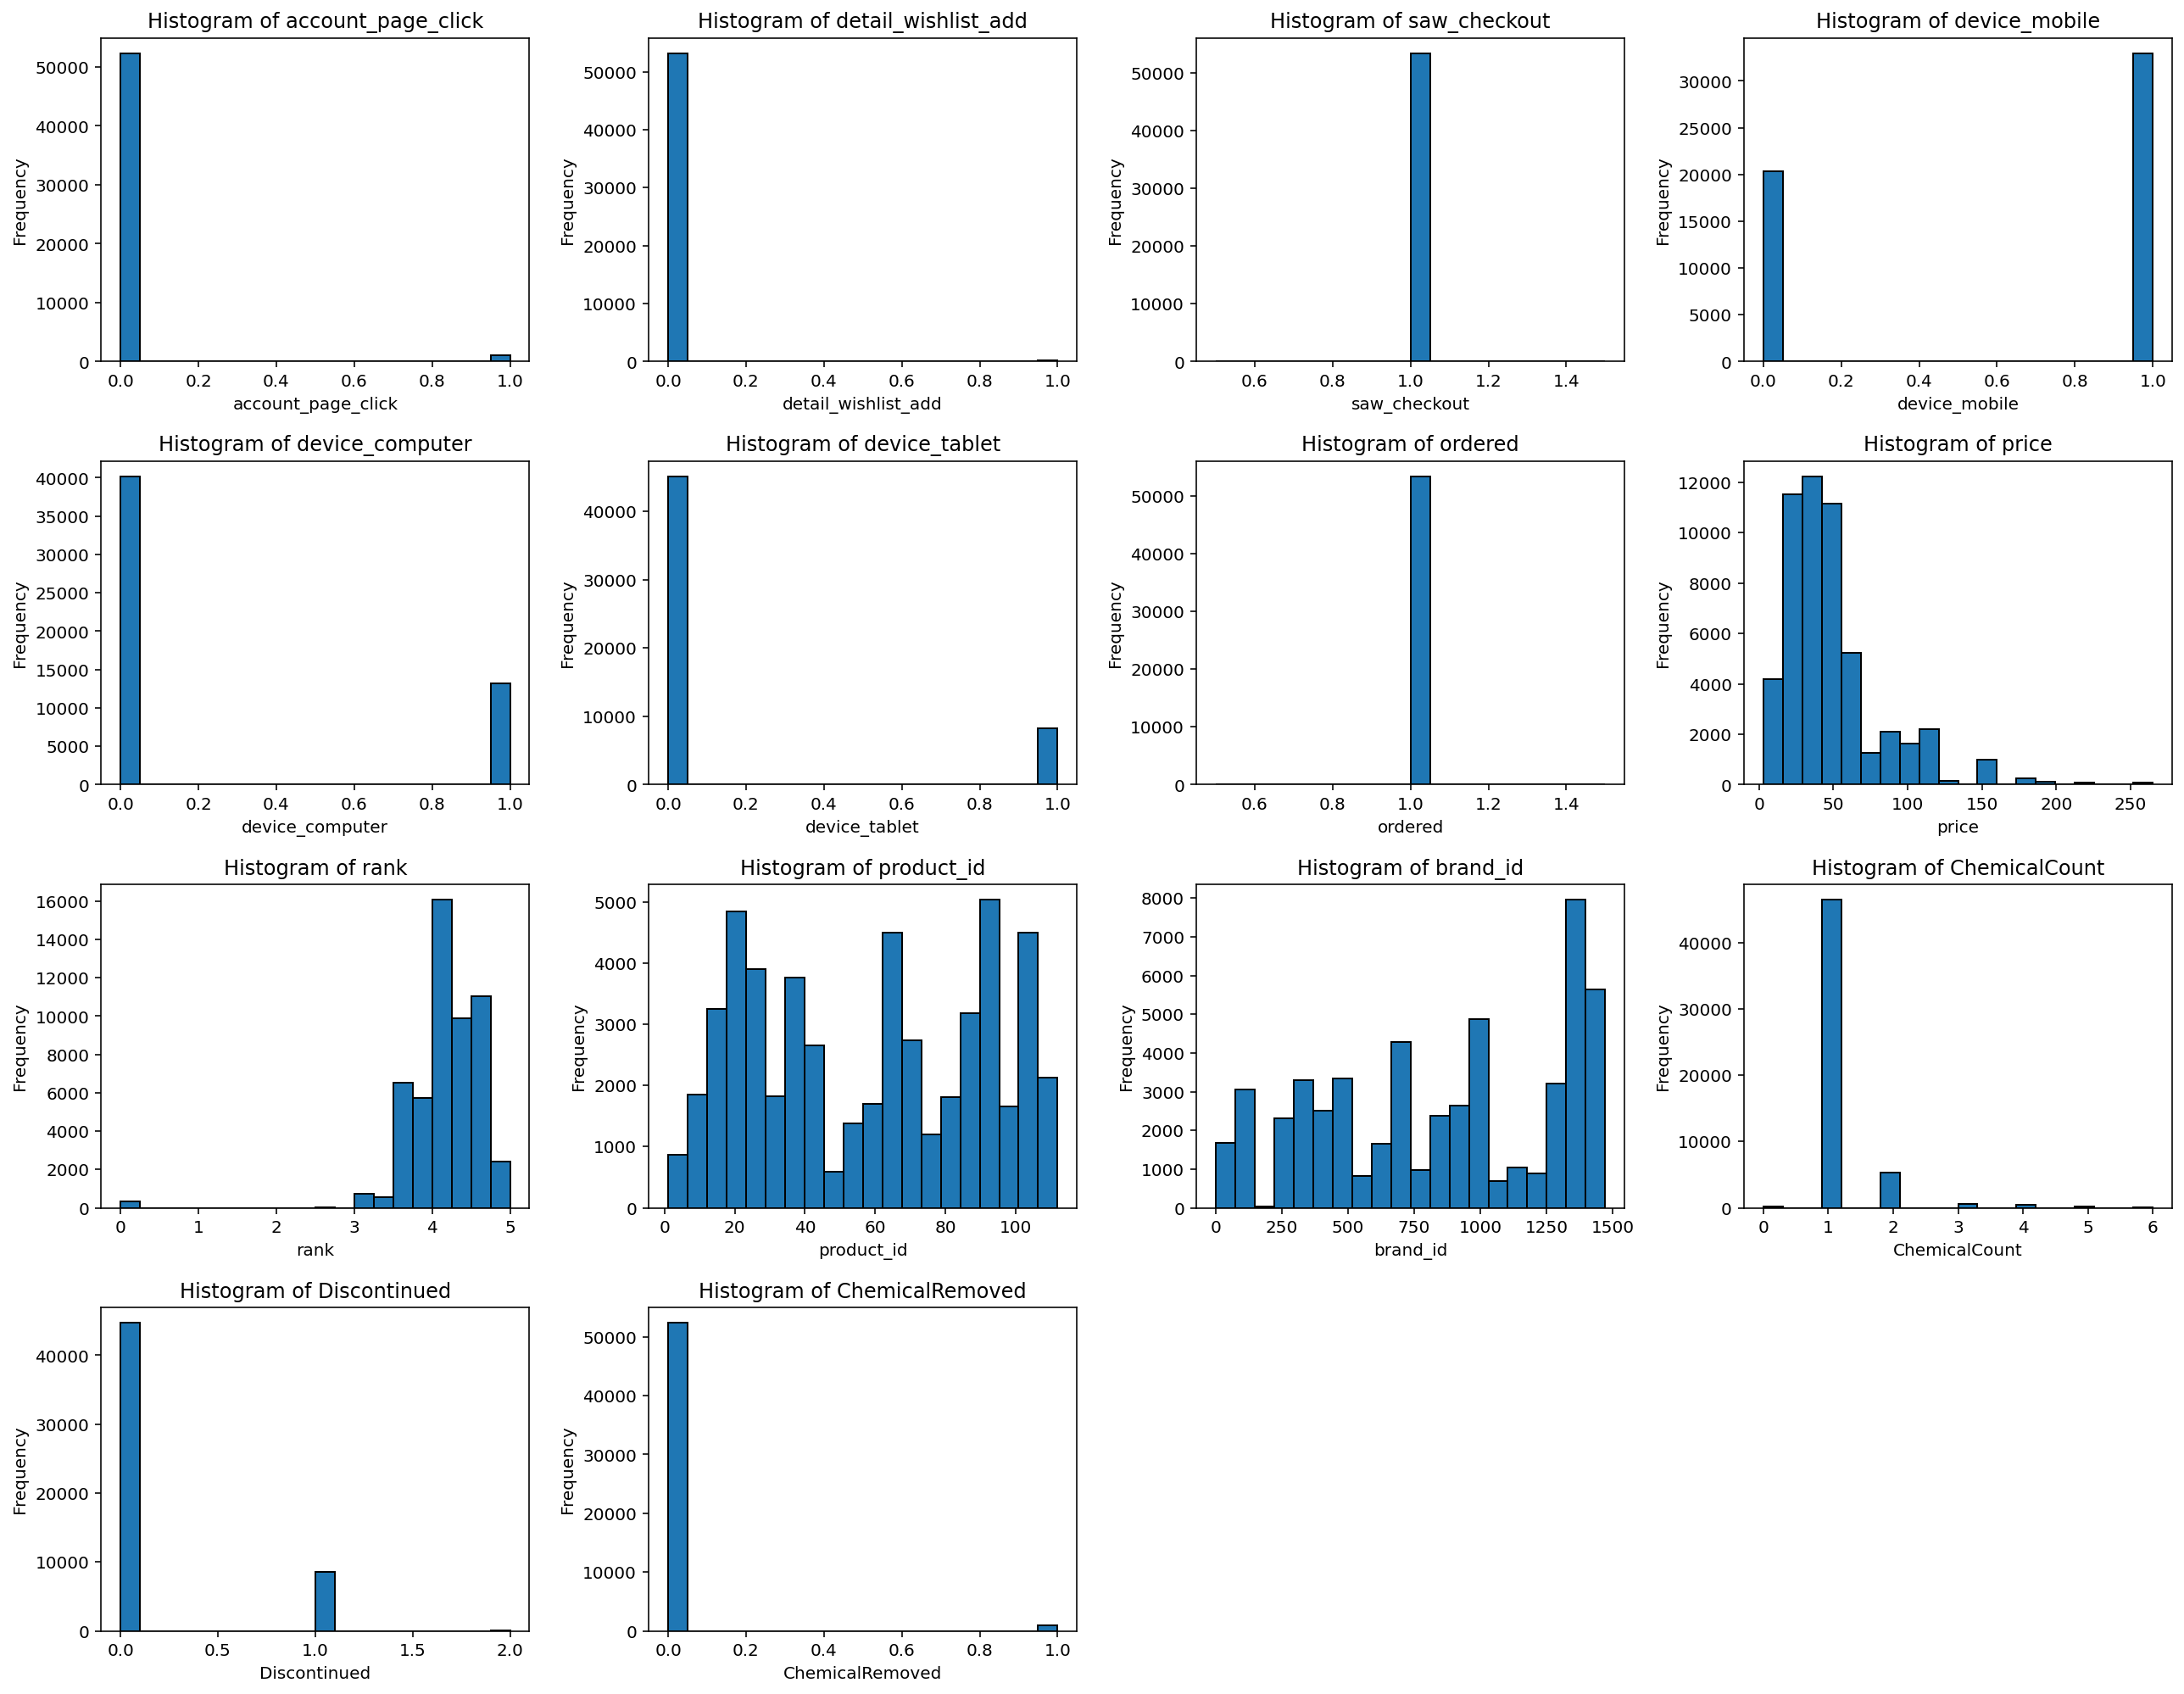

In [39]:
# list numerical predictors for histograms
predictors = [
    'account_page_click', 'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure
num_cols = 4
num_rows = (len(predictors) - 1) // num_cols + 1
plt.figure(figsize=(18, 14))  

# create histograms 
for i, predictor in enumerate(predictors):
    plt.subplot(num_rows, num_cols, i + 1)  
    plt.hist(sc_df[predictor], bins=20, edgecolor='black')
    plt.title(f'Histogram of {predictor}')
    plt.xlabel(predictor)
    plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()

#### Box Plots

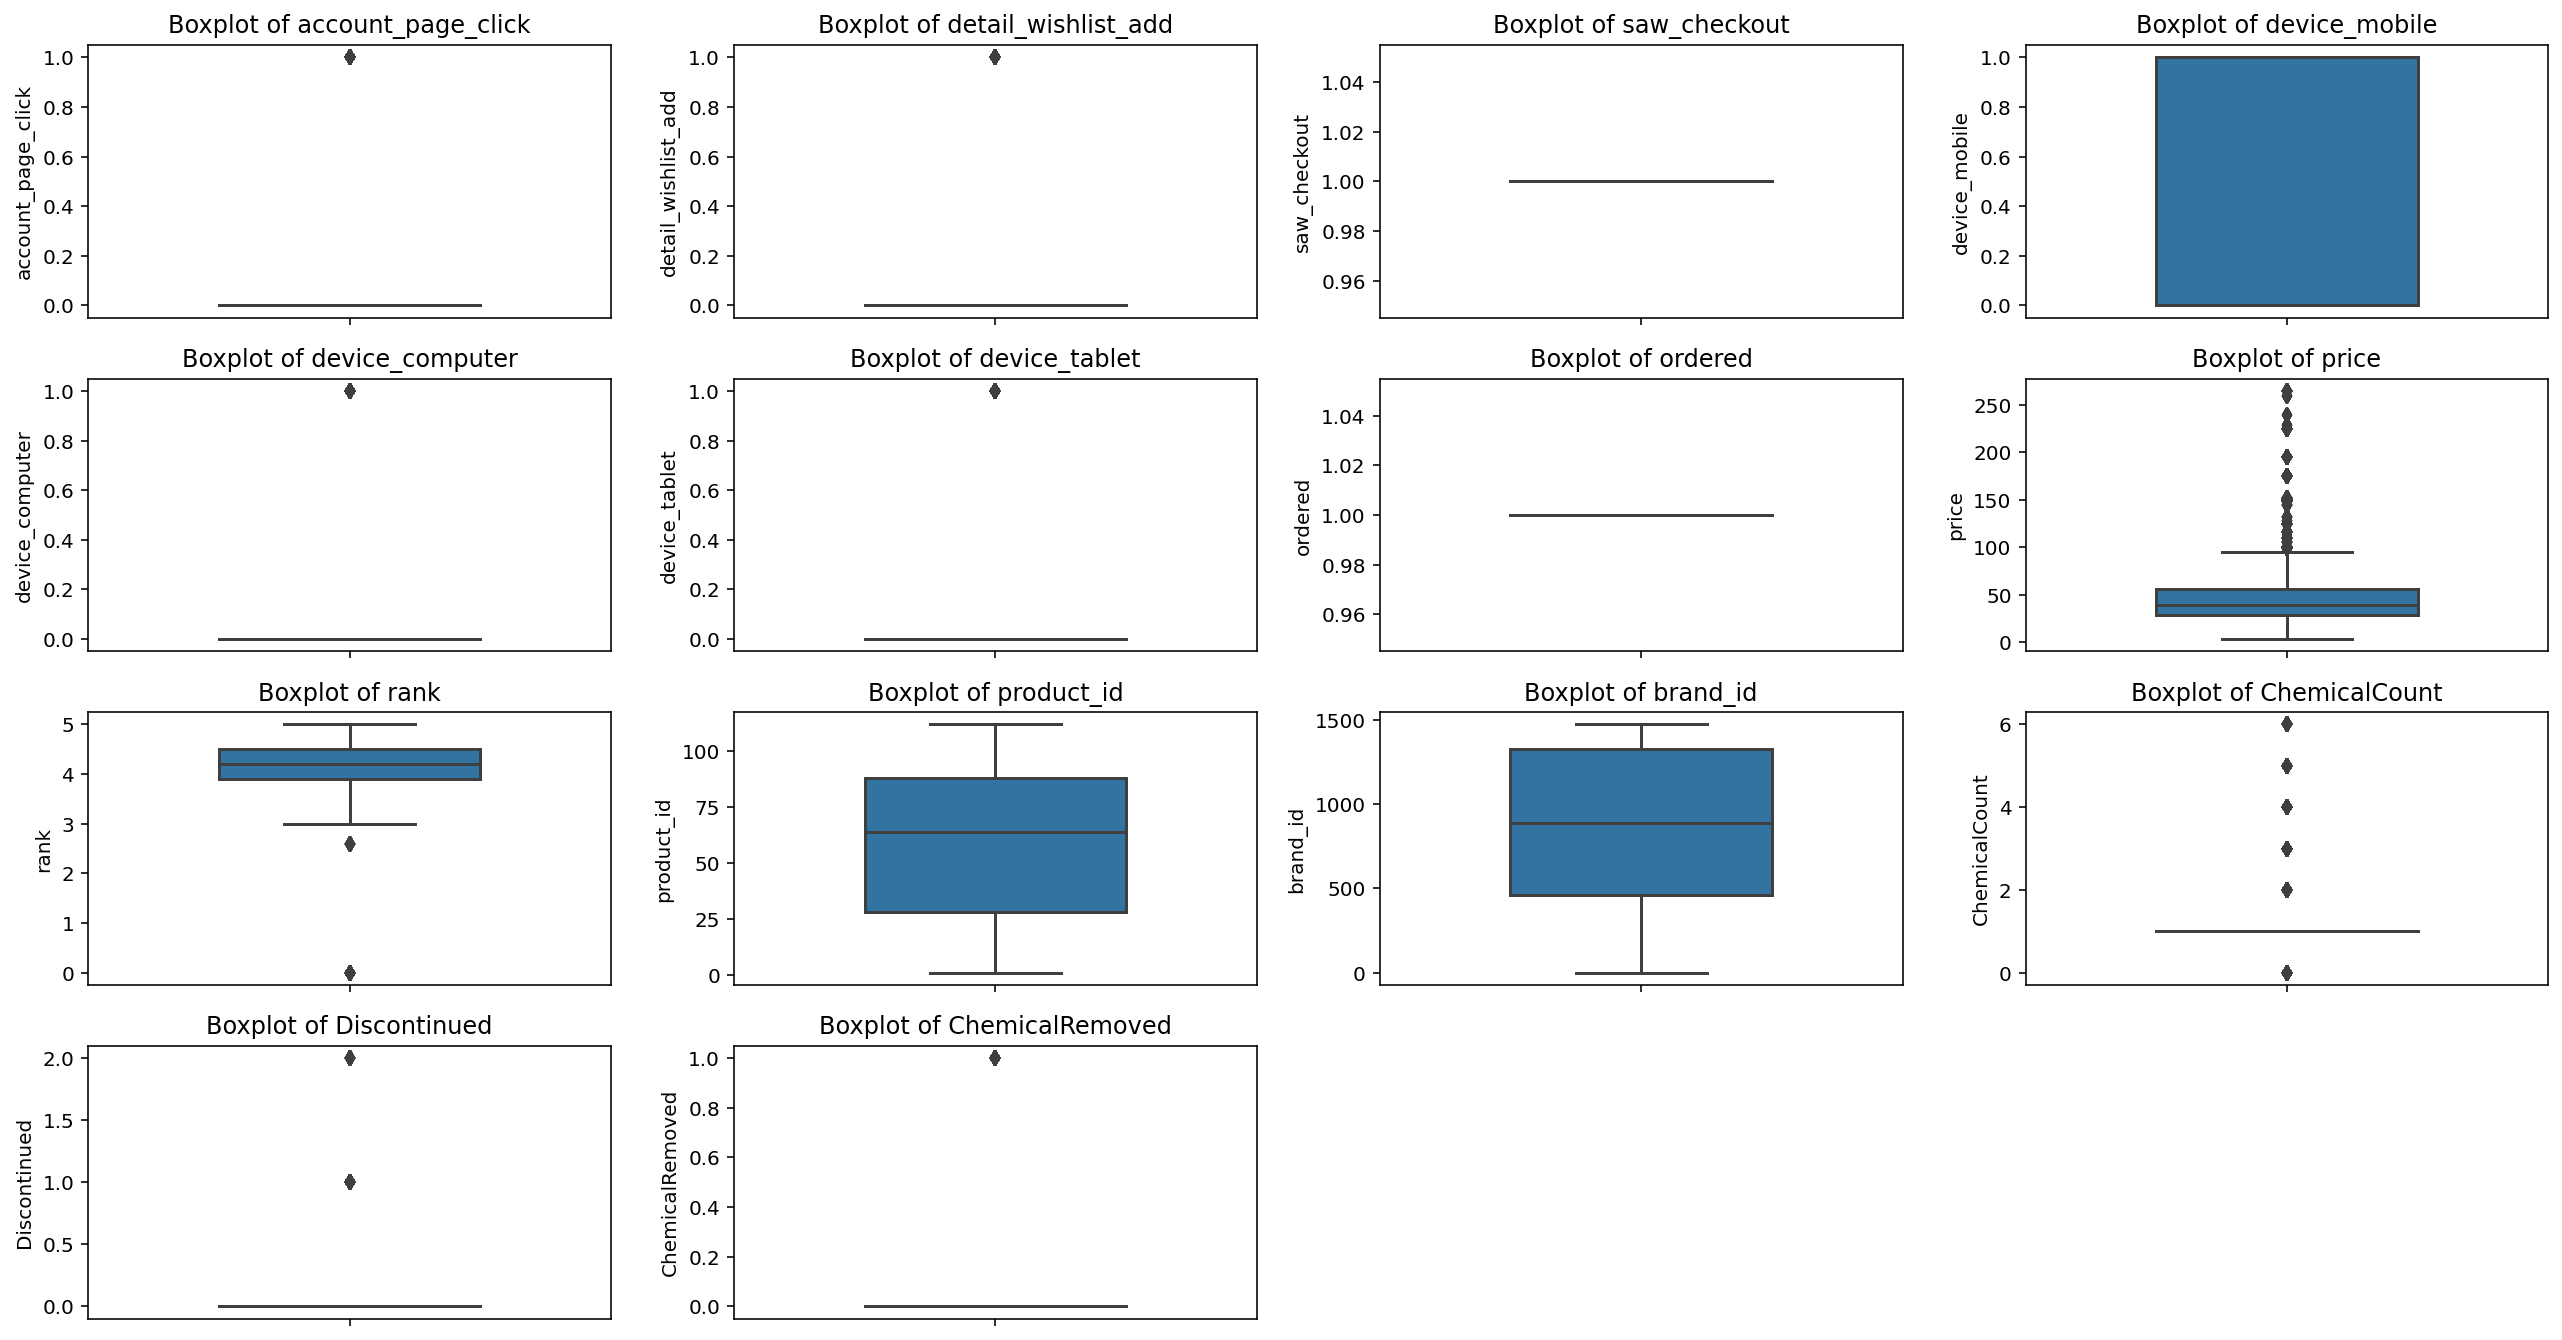

In [40]:
# list numerical predictors to create boxplots 
predictors = numerical_predictors = [
    'account_page_click','detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure for boxplots subplots 
plt.figure(figsize=(18, 14))  

# create boxplots for each predictor
for i, predictor in enumerate(predictors):
    plt.subplot(6, 4, i + 1)  
    sns.boxplot(data=sc_df, y=predictor, width=0.5)
    plt.title(f'Boxplot of {predictor}')
    plt.ylabel(predictor)

plt.tight_layout()  
plt.show()

#### Bar Plots 

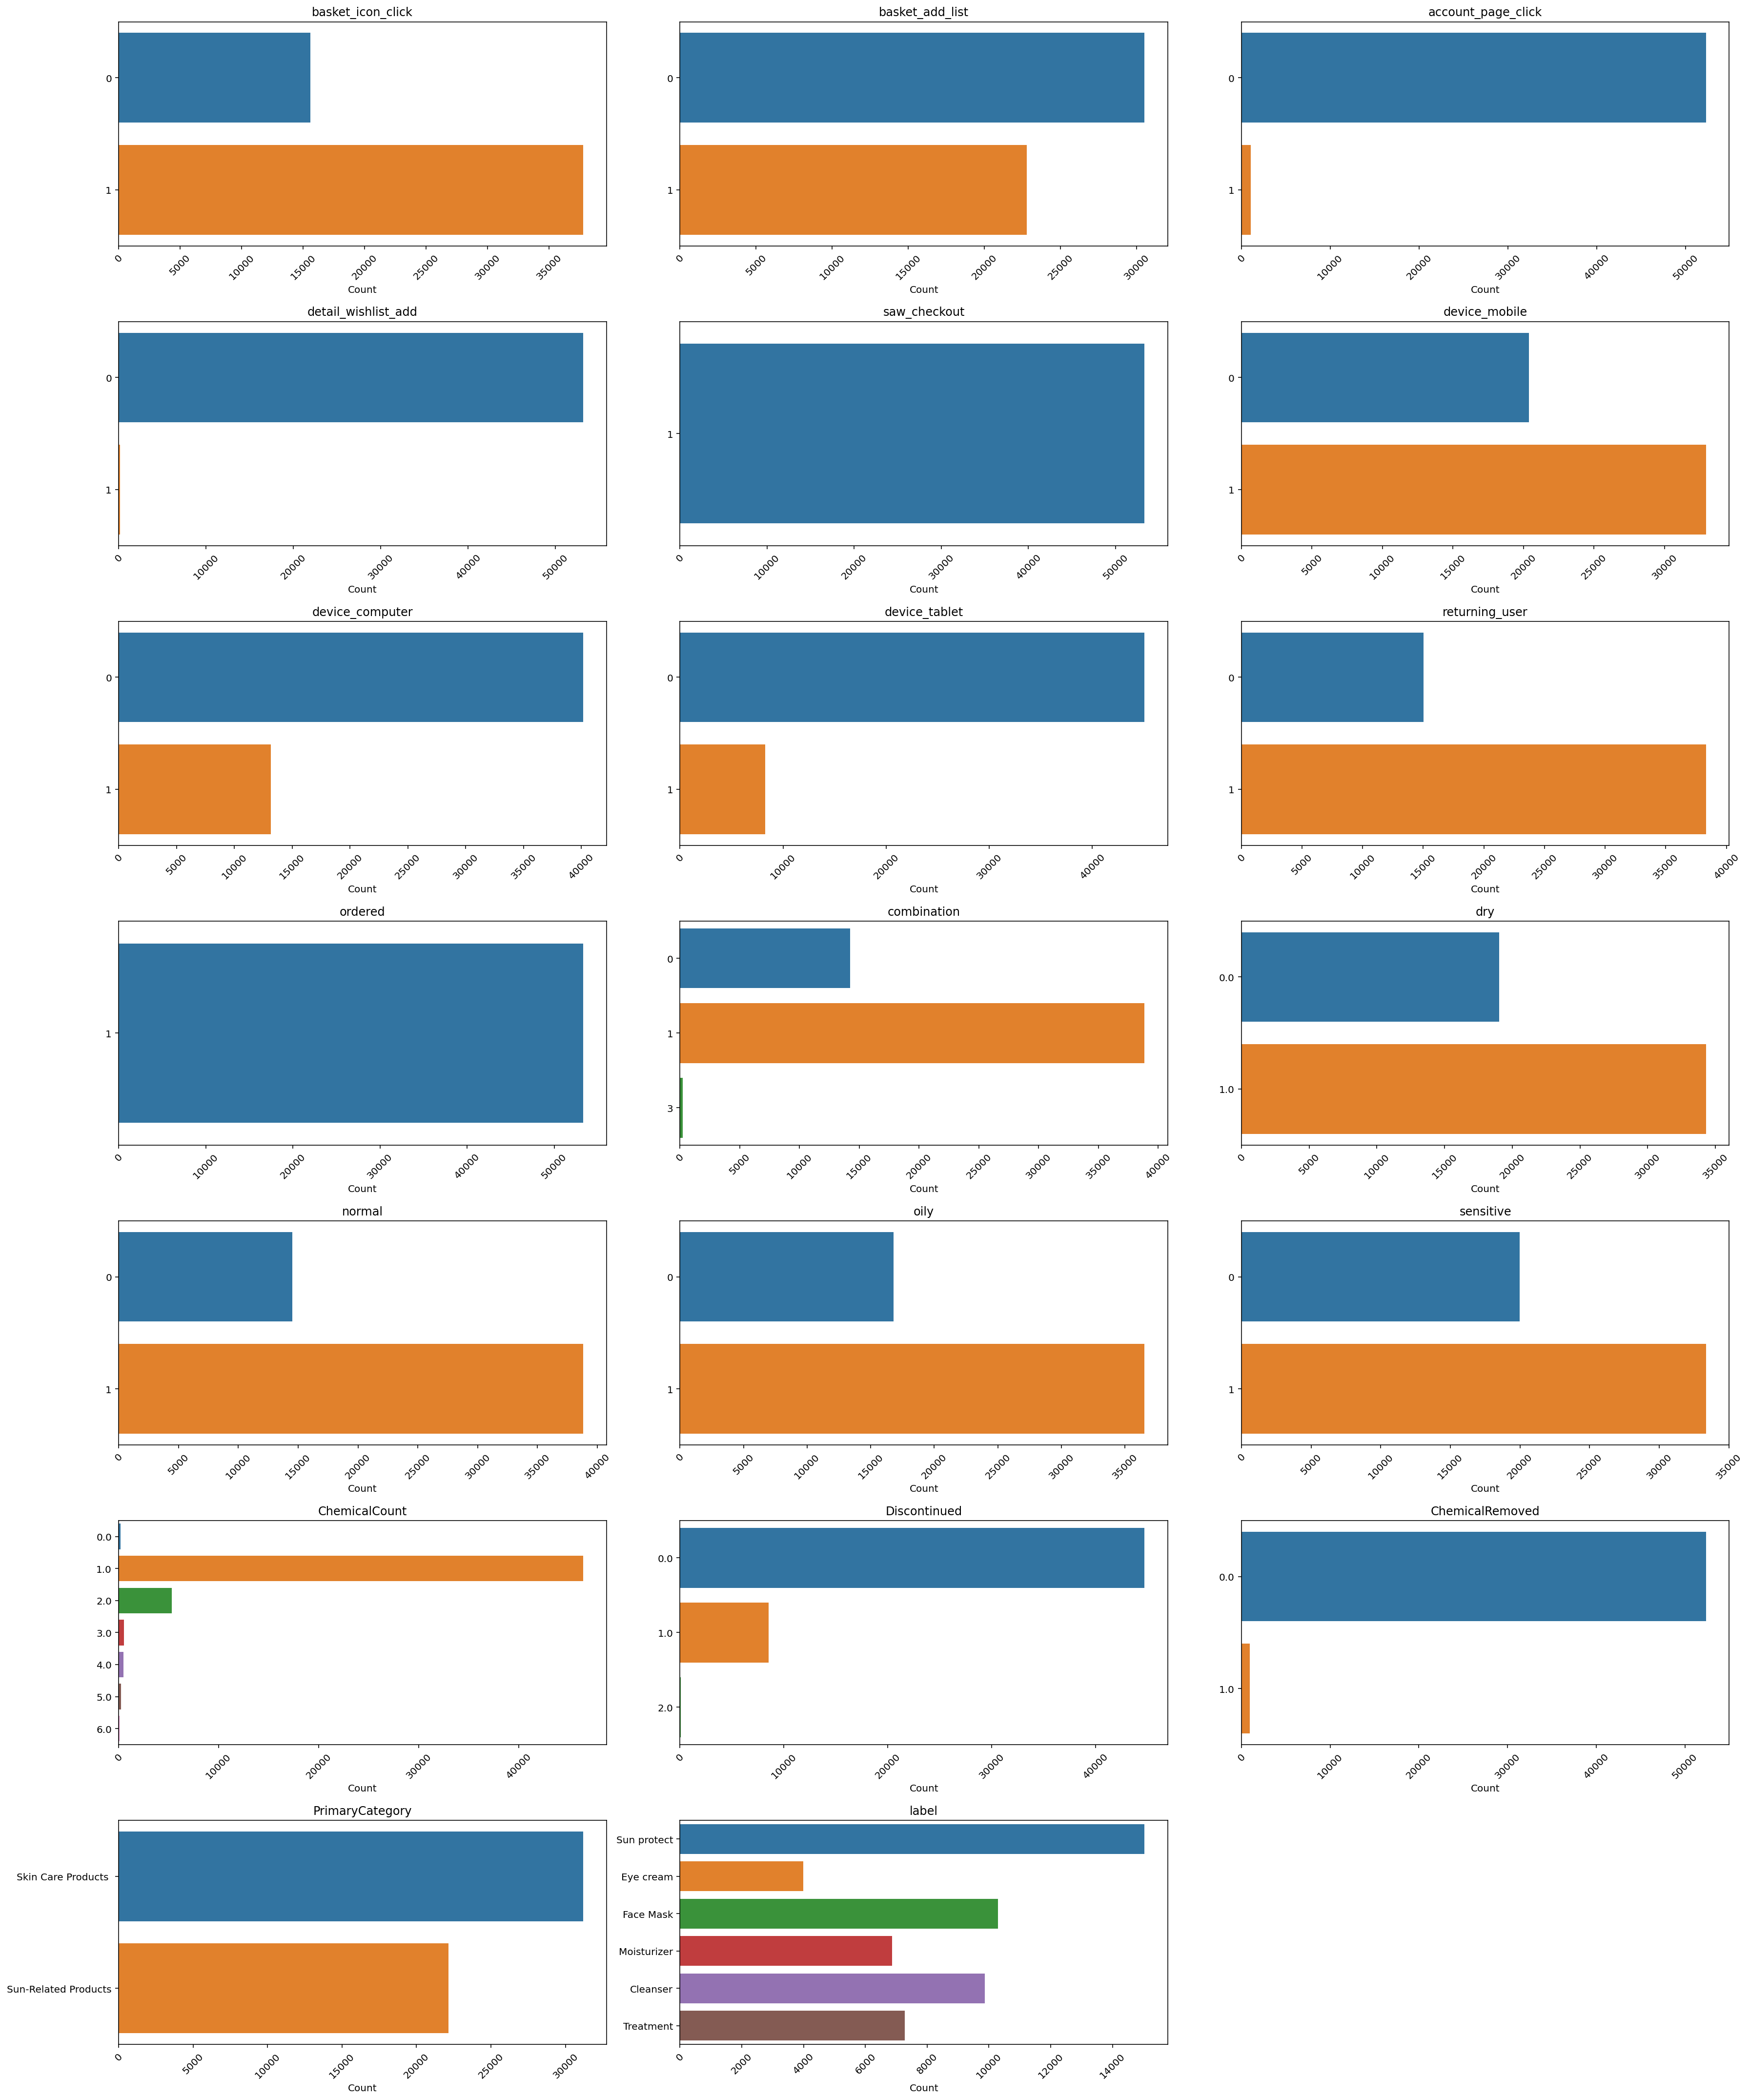

In [41]:
# list of selected columns for bar plot 
selected_columns = [
    'basket_icon_click', 'basket_add_list', 'account_page_click', 
    'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'returning_user', 
    'ordered', 'combination', 'dry', 'normal', 'oily', 'sensitive', 
    'ChemicalCount', 'Discontinued', 'ChemicalRemoved','PrimaryCategory', 'label'
]

# calculate the number of rows and columns for the subplot grid
num_cols = 3
num_rows = (len(selected_columns) - 1) // num_cols + 1

# create subplots and flatten axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 30))
axes = axes.flatten()

# iterate through selected columns and create horizontal countplots
for i, column in enumerate(selected_columns):
    sns.countplot(data=sc_df, y=column, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)  

    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')

# remove empty subplots
for i in range(len(selected_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### Class Imbalance 
#### ('ordered' and 'saw_checkout')

In [55]:
# check distribution of classes before adding class
print("\nBefore balancing:")
print(sc_df['ordered'].value_counts())
print(sc_df['saw_checkout'].value_counts())


Before balancing:
1    53325
Name: ordered, dtype: int64
1    53325
Name: saw_checkout, dtype: int64


In [58]:
sc_shuffled = sc_df.sample(frac=1, random_state=42)

# Calculate the number of '1' samples to preserve the original proportion
num_class_1_samples = len(sc_shuffled[(sc_shuffled['ordered'] == 1) | (sc_shuffled['saw_checkout'] == 1)])

# Calculate the number of '0' samples to add
num_class_0_samples = int(num_class_1_samples * 0.1)  # 10% of '1' samples

# Select random samples from the dataframe to assign new class 's0'
class_0_samples = sc_shuffled.sample(n=num_class_0_samples, random_state=42).index
sc_shuffled.loc[class_0_samples, 'ordered'] = '0'
sc_shuffled.loc[class_0_samples, 'saw_checkout'] = '0'

# Check the distribution after adding the new class
print("After adding new class:")
print("Ordered:")
print(sc_shuffled['ordered'].value_counts())
print("\nSaw Checkout:")
print(sc_shuffled['saw_checkout'].value_counts())

After adding new class:
Ordered:
1    47993
0     5332
Name: ordered, dtype: int64

Saw Checkout:
1    47993
0     5332
Name: saw_checkout, dtype: int64


In [85]:
sc_shuffled['ordered'] = sc_shuffled['ordered'].astype(int)
sc_shuffled['saw_checkout'] = sc_shuffled['saw_checkout'].astype(int)

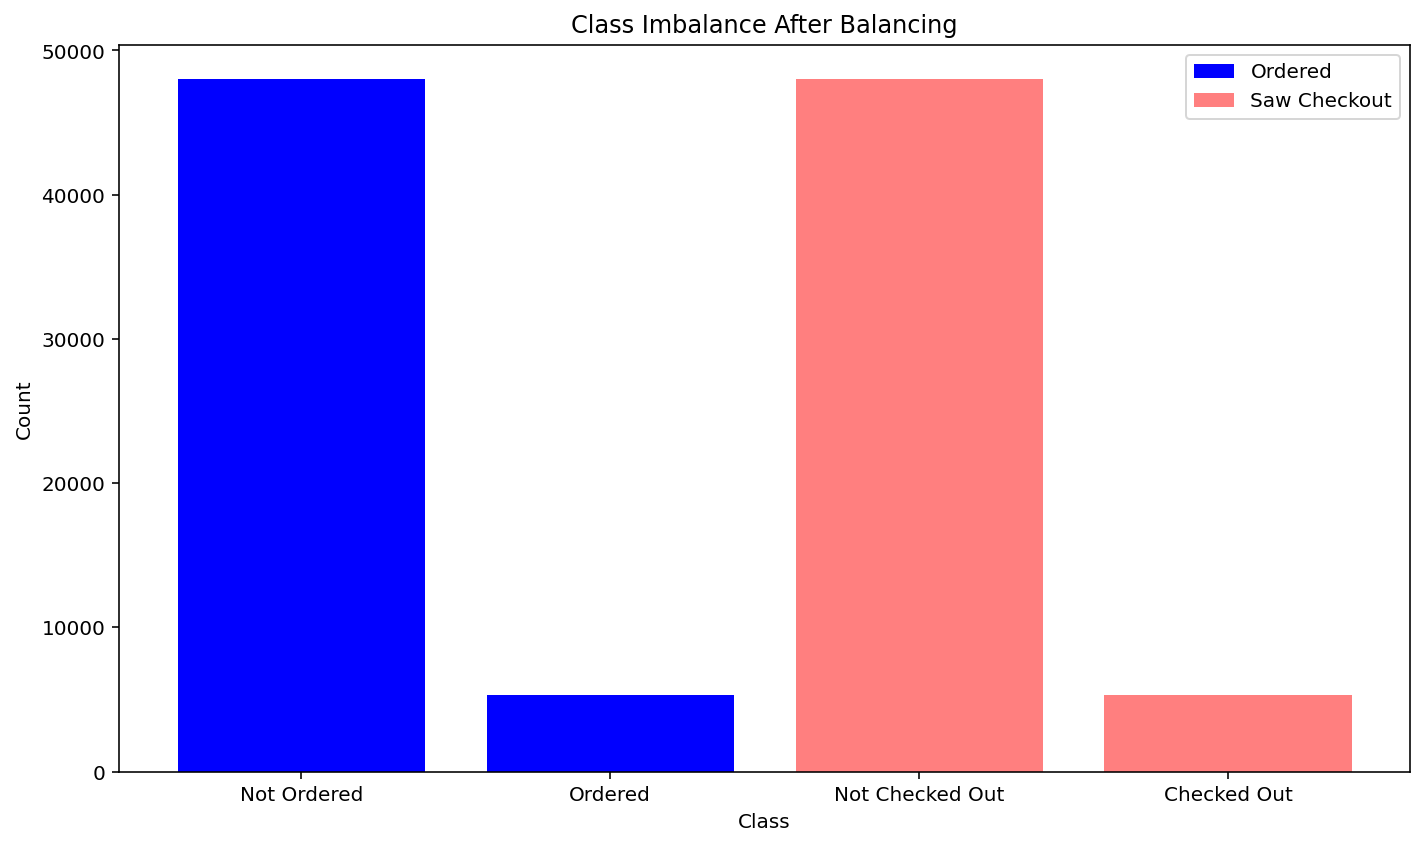

In [60]:
plt.figure(figsize=(10, 6))

# Bar plot for 'ordered' column
plt.bar(['Not Ordered', 'Ordered'], sc_shuffled['ordered'].value_counts(), color='blue', label='Ordered')

# Bar plot for 'saw_checkout' column
plt.bar(['Not Checked Out', 'Checked Out'], sc_shuffled['saw_checkout'].value_counts(), color='red', label='Saw Checkout', alpha=0.5)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance After Balancing')
plt.legend()
plt.tight_layout()

plt.show()

In [86]:
checkout_distribution = sc_shuffled['saw_checkout'].value_counts(normalize=True)
print("Class Distribution for Saw Check Out:\n", checkout_distribution)

ordered_distribution = sc_shuffled['ordered'].value_counts(normalize=True)
print("Class Distribution for Ordered:\n", ordered_distribution)

Class Distribution for Saw Check Out:
 1    0.900009
0    0.099991
Name: saw_checkout, dtype: float64
Class Distribution for Ordered:
 1    0.900009
0    0.099991
Name: ordered, dtype: float64


In [87]:
balanced_df = sc_shuffled.copy()
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53325 entries, 31078 to 15795
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               53325 non-null  object 
 1   basket_icon_click    53325 non-null  int64  
 2   basket_add_list      53325 non-null  int64  
 3   account_page_click   53325 non-null  int64  
 4   detail_wishlist_add  53325 non-null  int64  
 5   saw_checkout         53325 non-null  int64  
 6   device_mobile        53325 non-null  int64  
 7   device_computer      53325 non-null  int64  
 8   device_tablet        53325 non-null  int64  
 9   returning_user       53325 non-null  int64  
 10  ordered              53325 non-null  int64  
 11  label                53325 non-null  object 
 12  brand                53325 non-null  object 
 13  name                 53325 non-null  object 
 14  price                53325 non-null  float64
 15  rank                 53325 non-n

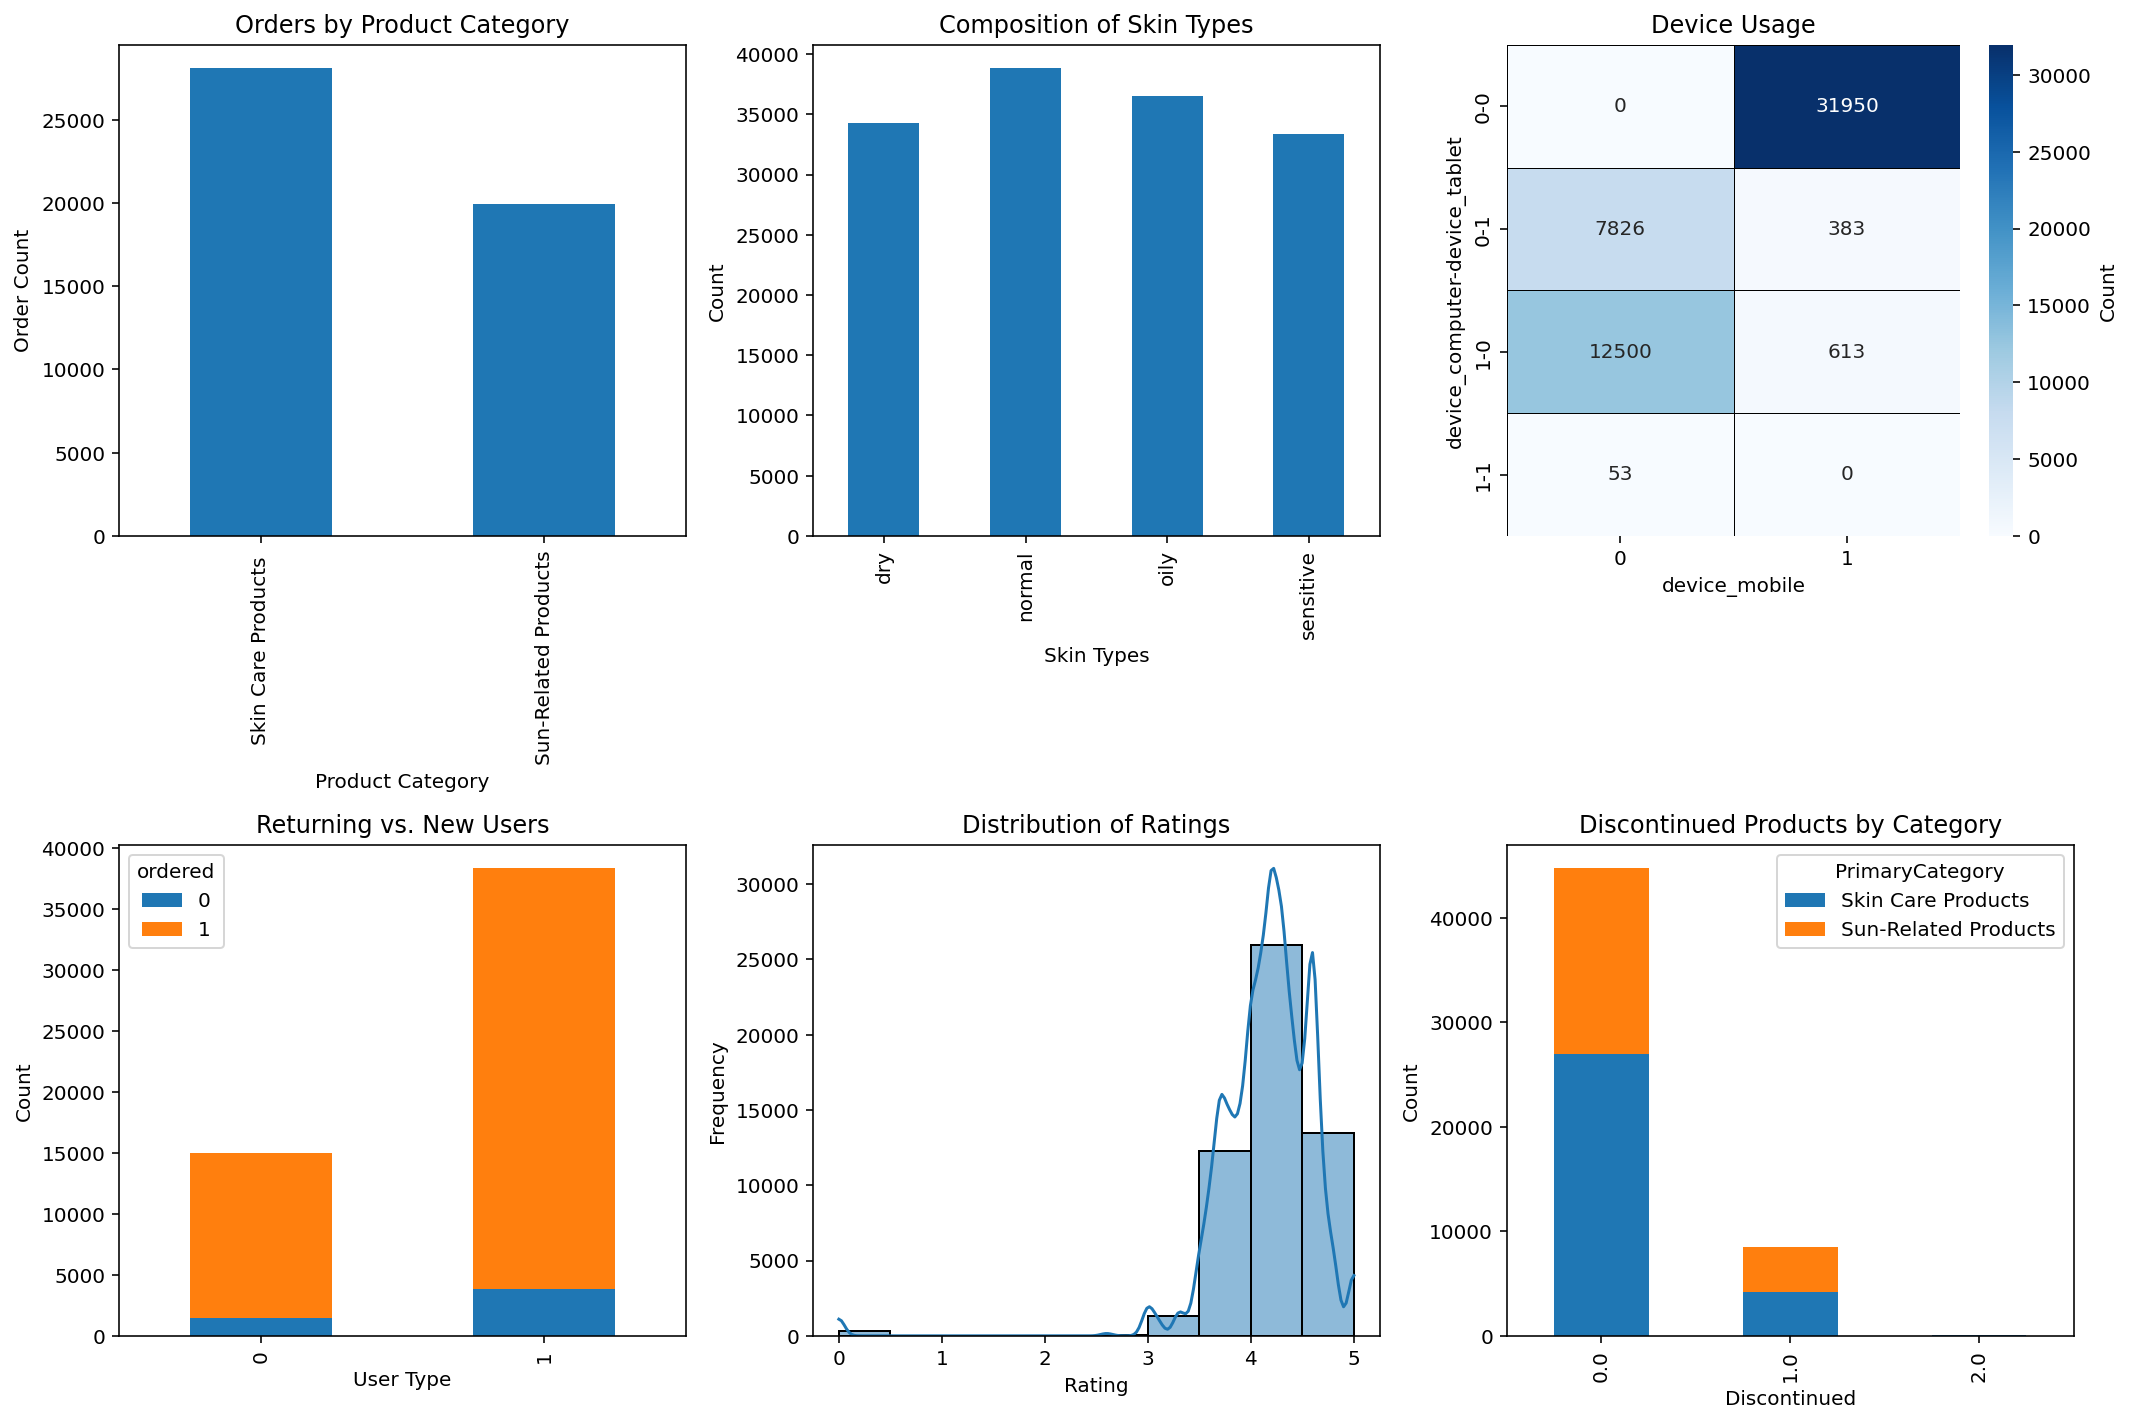

In [88]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# count of ordered by product category
order_count_by_category = balanced_df.groupby('PrimaryCategory')['ordered'].sum()
order_count_by_category.plot(kind='bar', ax=axs[0, 0], 
                             xlabel='Product Category', ylabel='Order Count', 
                             title='Orders by Product Category')

# composition of skin types
skin_type_counts = balanced_df[['dry', 'normal', 'oily', 'sensitive']].sum()
skin_type_counts.plot(kind='bar', stacked=True, ax=axs[0, 1], 
                      xlabel='Skin Types', ylabel='Count', 
                      title='Composition of Skin Types')

# device usage 
device_usage = balanced_df[['device_computer', 'device_tablet', 'device_mobile']].astype(int)
device_usage_counts = device_usage.groupby(device_usage.columns.tolist()).size().unstack(fill_value=0)
sns.heatmap(device_usage_counts, ax=axs[0, 2], cmap="Blues", annot=True, fmt="d",
            cbar_kws={'label': 'Count'}, 
            linewidths=0.5, linecolor='black')
axs[0, 2].set_title('Device Usage')

# returning vs new users 
returning_new_users = pd.crosstab(balanced_df['returning_user'], 
                                  balanced_df['ordered'])

returning_new_users.plot(kind='bar', stacked=True, ax=axs[1, 0], 
                         xlabel='User Type', ylabel='Count', 
                         title='Returning vs. New Users')

# distribution of ratings 
sns.histplot(data=balanced_df, x='rank', bins=10, kde=True, ax=axs[1, 1])
axs[1, 1].set_xlabel('Rating')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution of Ratings')

# discontinued products 
discontinued_category_counts = pd.crosstab(index=balanced_df['Discontinued'], 
                                           columns=balanced_df['PrimaryCategory'])

discontinued_category_counts.plot(kind='bar', stacked=True, ax=axs[1, 2], 
                                  xlabel='Discontinued', ylabel='Count', 
                                  title='Discontinued Products by Category')

plt.tight_layout()
plt.show()

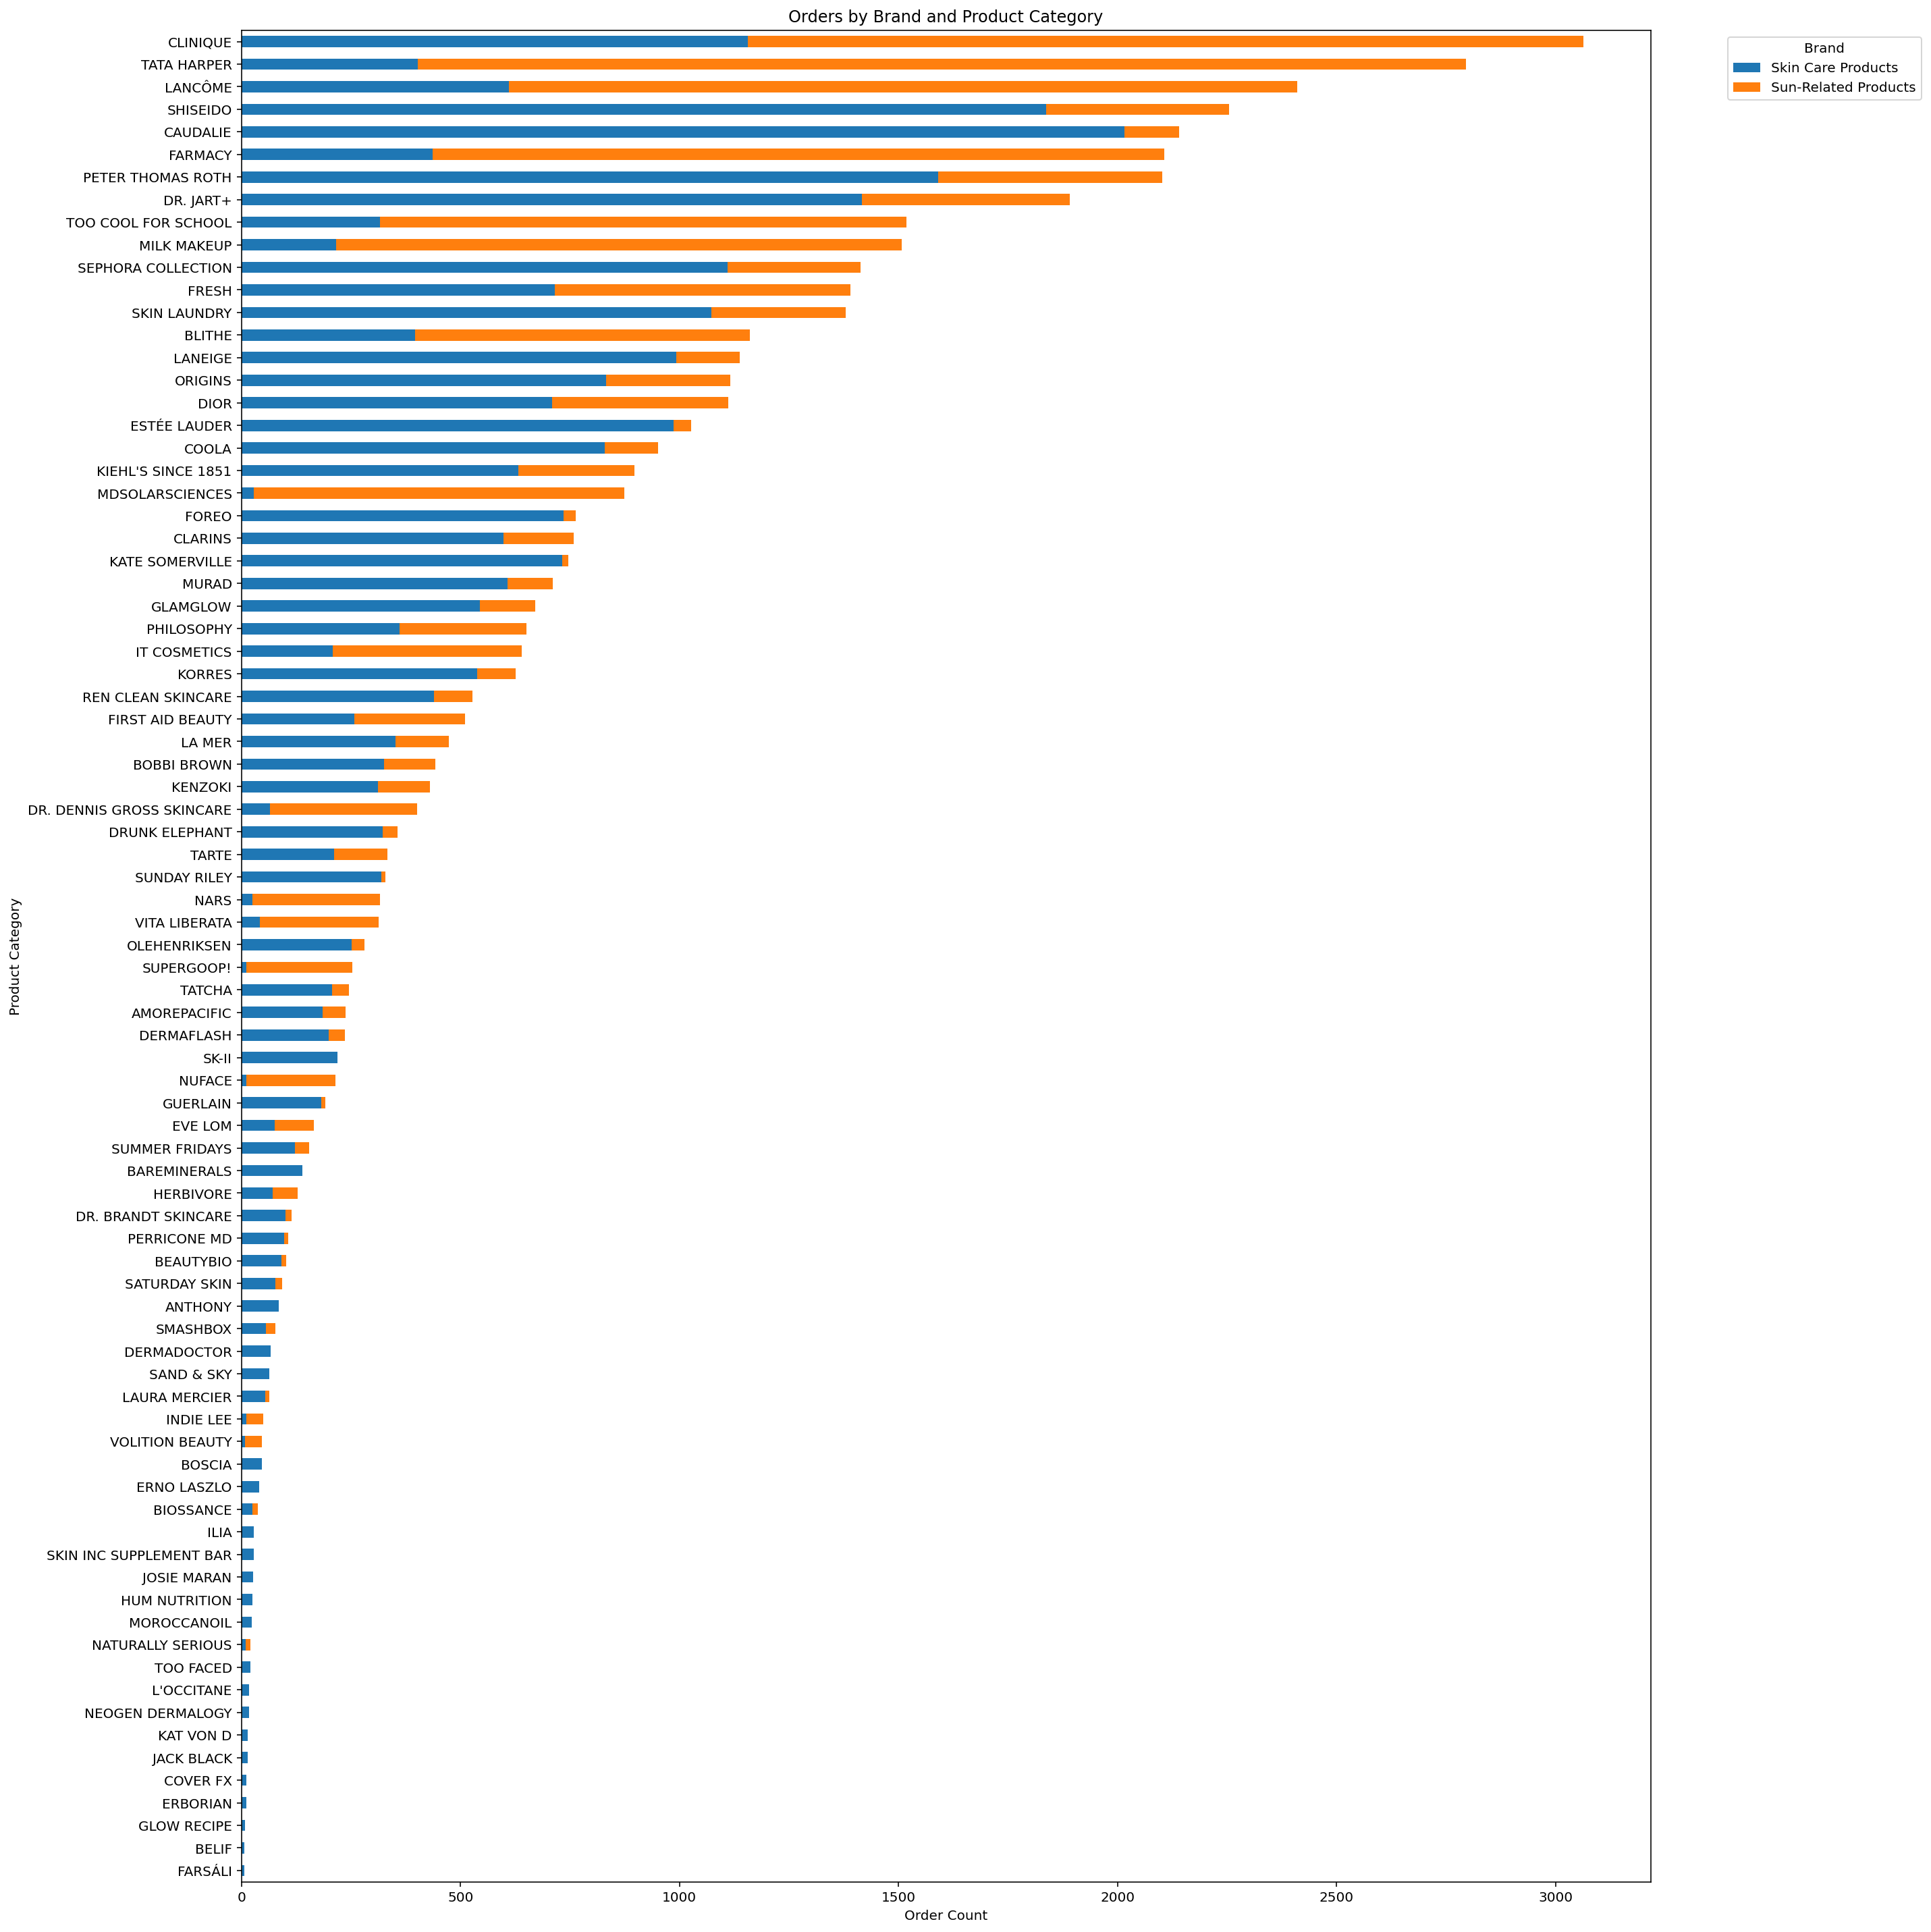

In [89]:
#  order count by brand and product category
order_count_by_brand_category = balanced_df.groupby(['brand', 'PrimaryCategory'])['ordered'].sum().unstack().fillna(0)
order_count_by_brand = order_count_by_brand_category.sum(axis=1).sort_values()
order_count_by_brand_category = order_count_by_brand_category.loc[order_count_by_brand.index]


order_count_by_brand_category.plot(kind='barh', stacked=True, figsize=(20, 20))
plt.xlabel('Order Count')
plt.ylabel('Product Category')
plt.title('Orders by Brand and Product Category')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

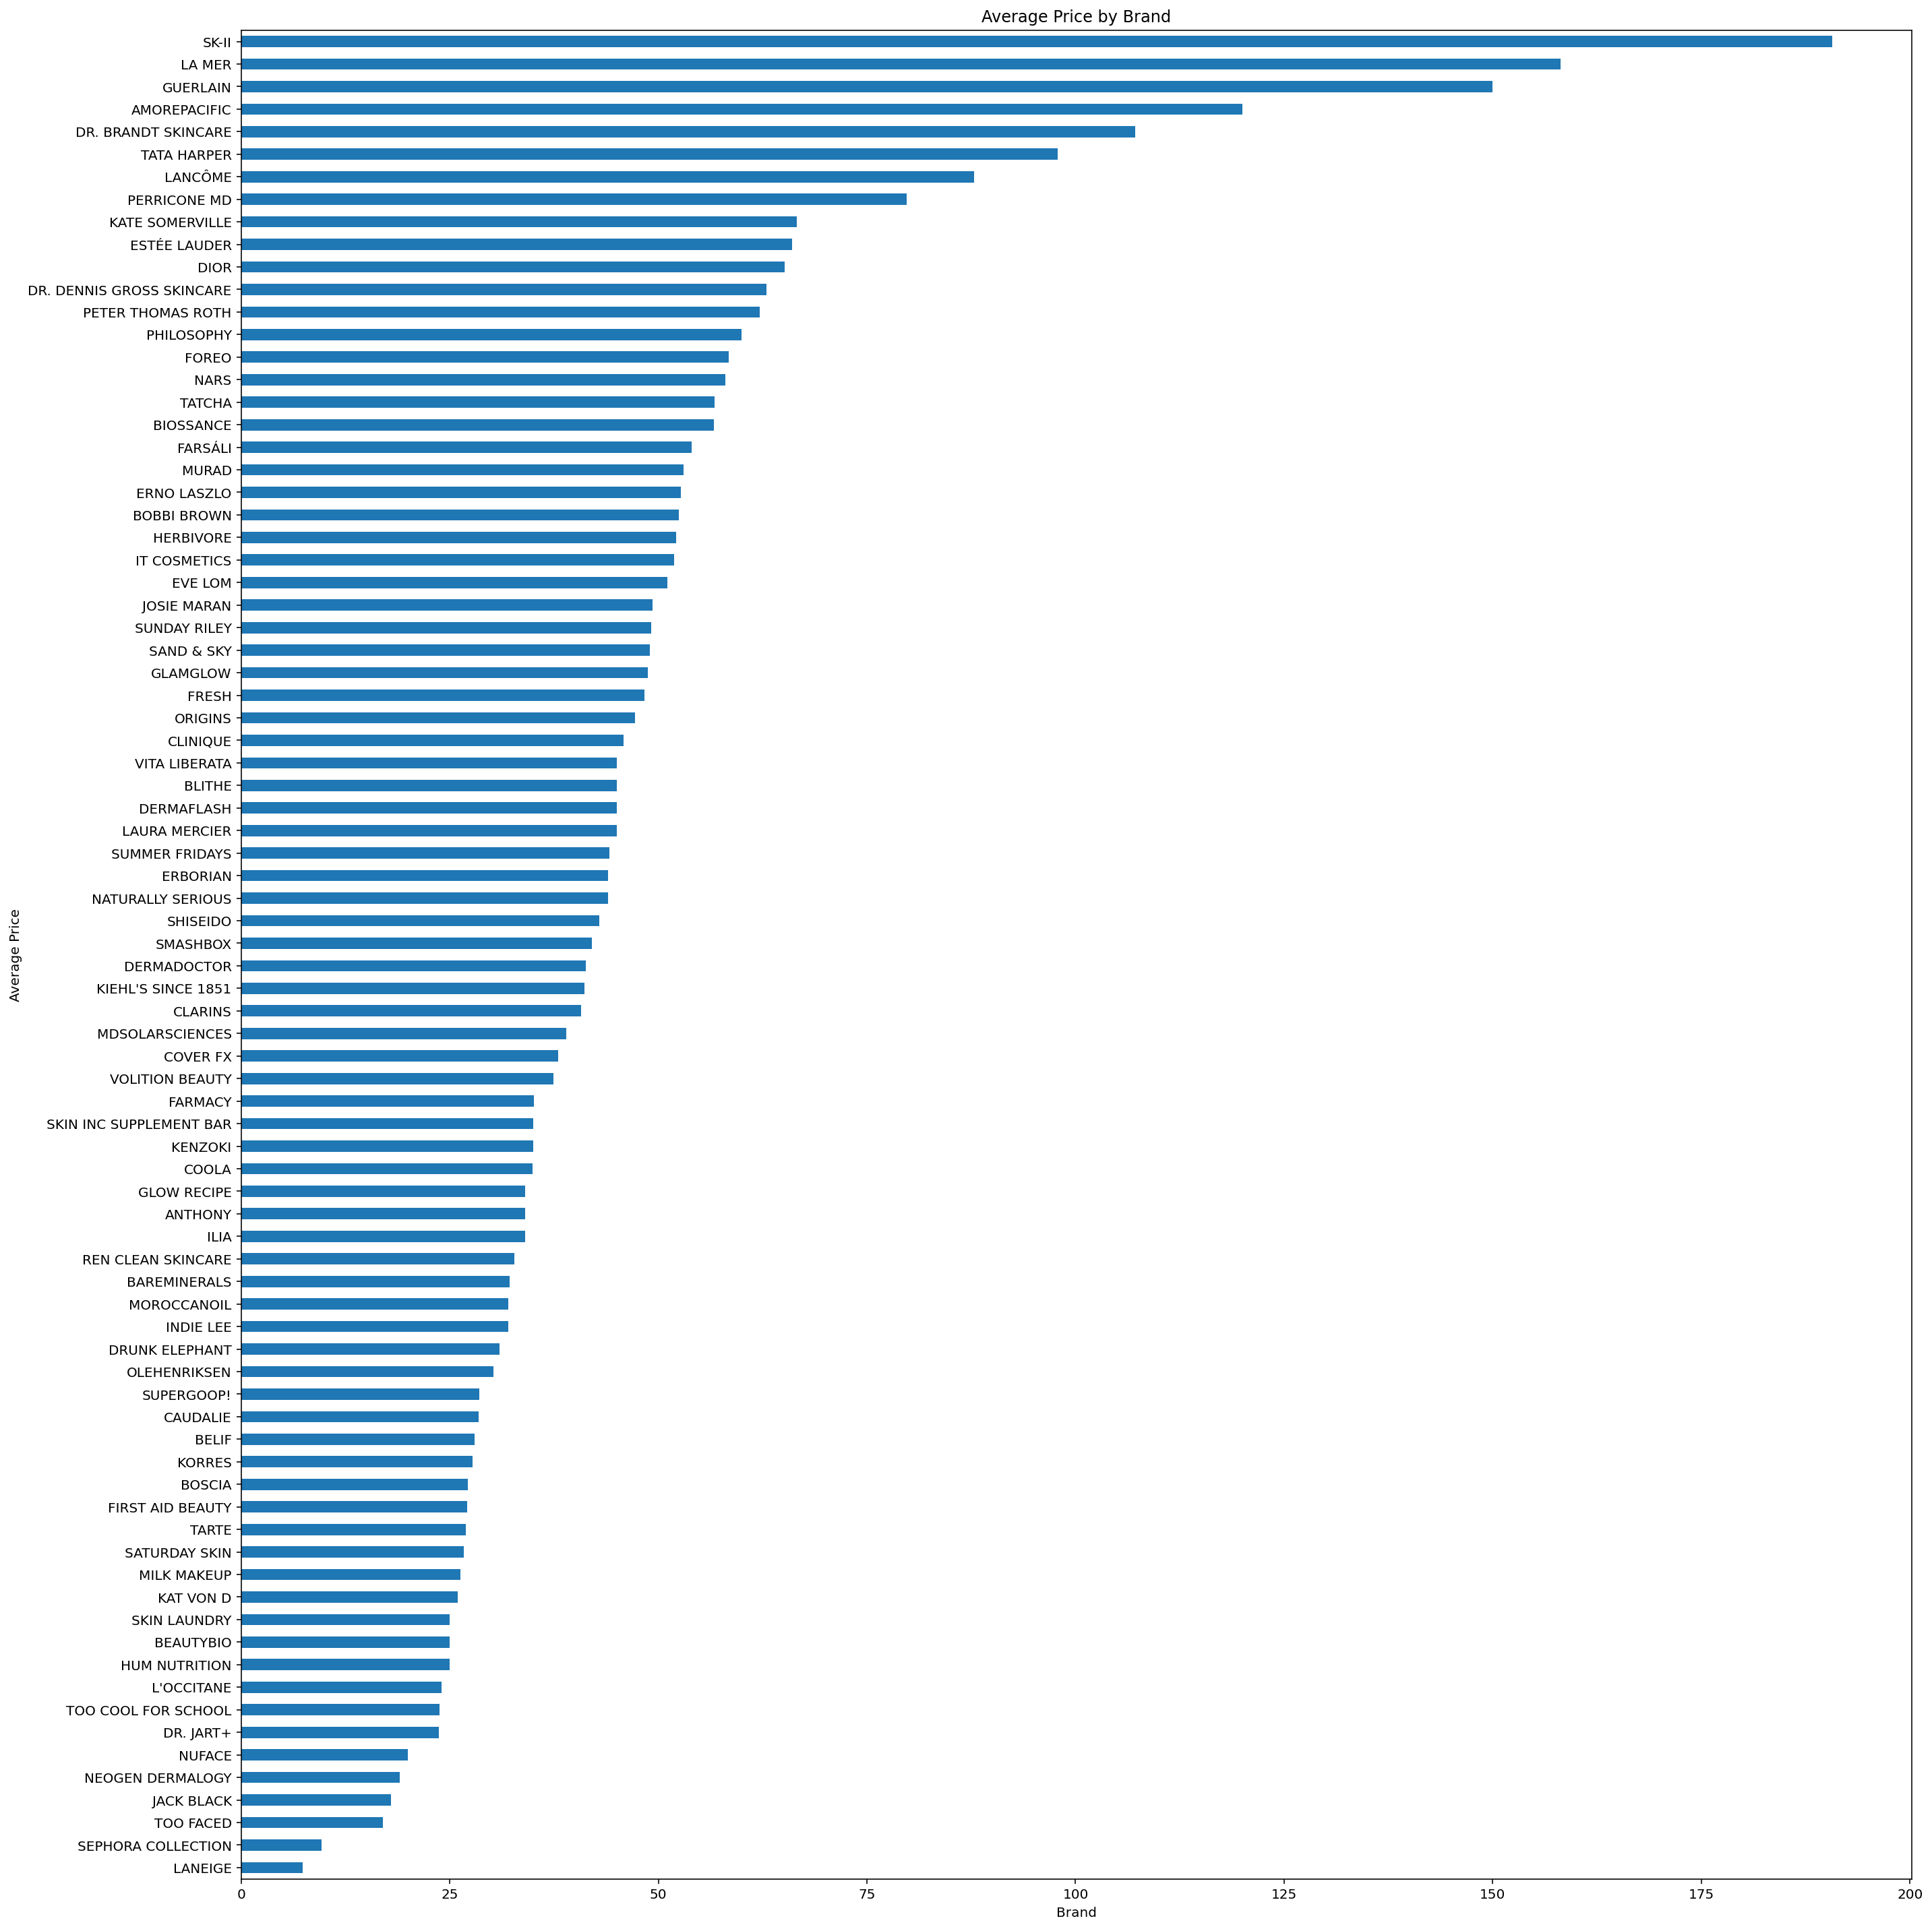

In [90]:
# plot the average price by brand
avg_price_by_brand = balanced_df.groupby('brand')['price'].mean().sort_values()

plt.figure(figsize=(20, 20))
avg_price_by_brand.plot(kind='barh')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.title('Average Price by Brand')
plt.tight_layout()
plt.show()

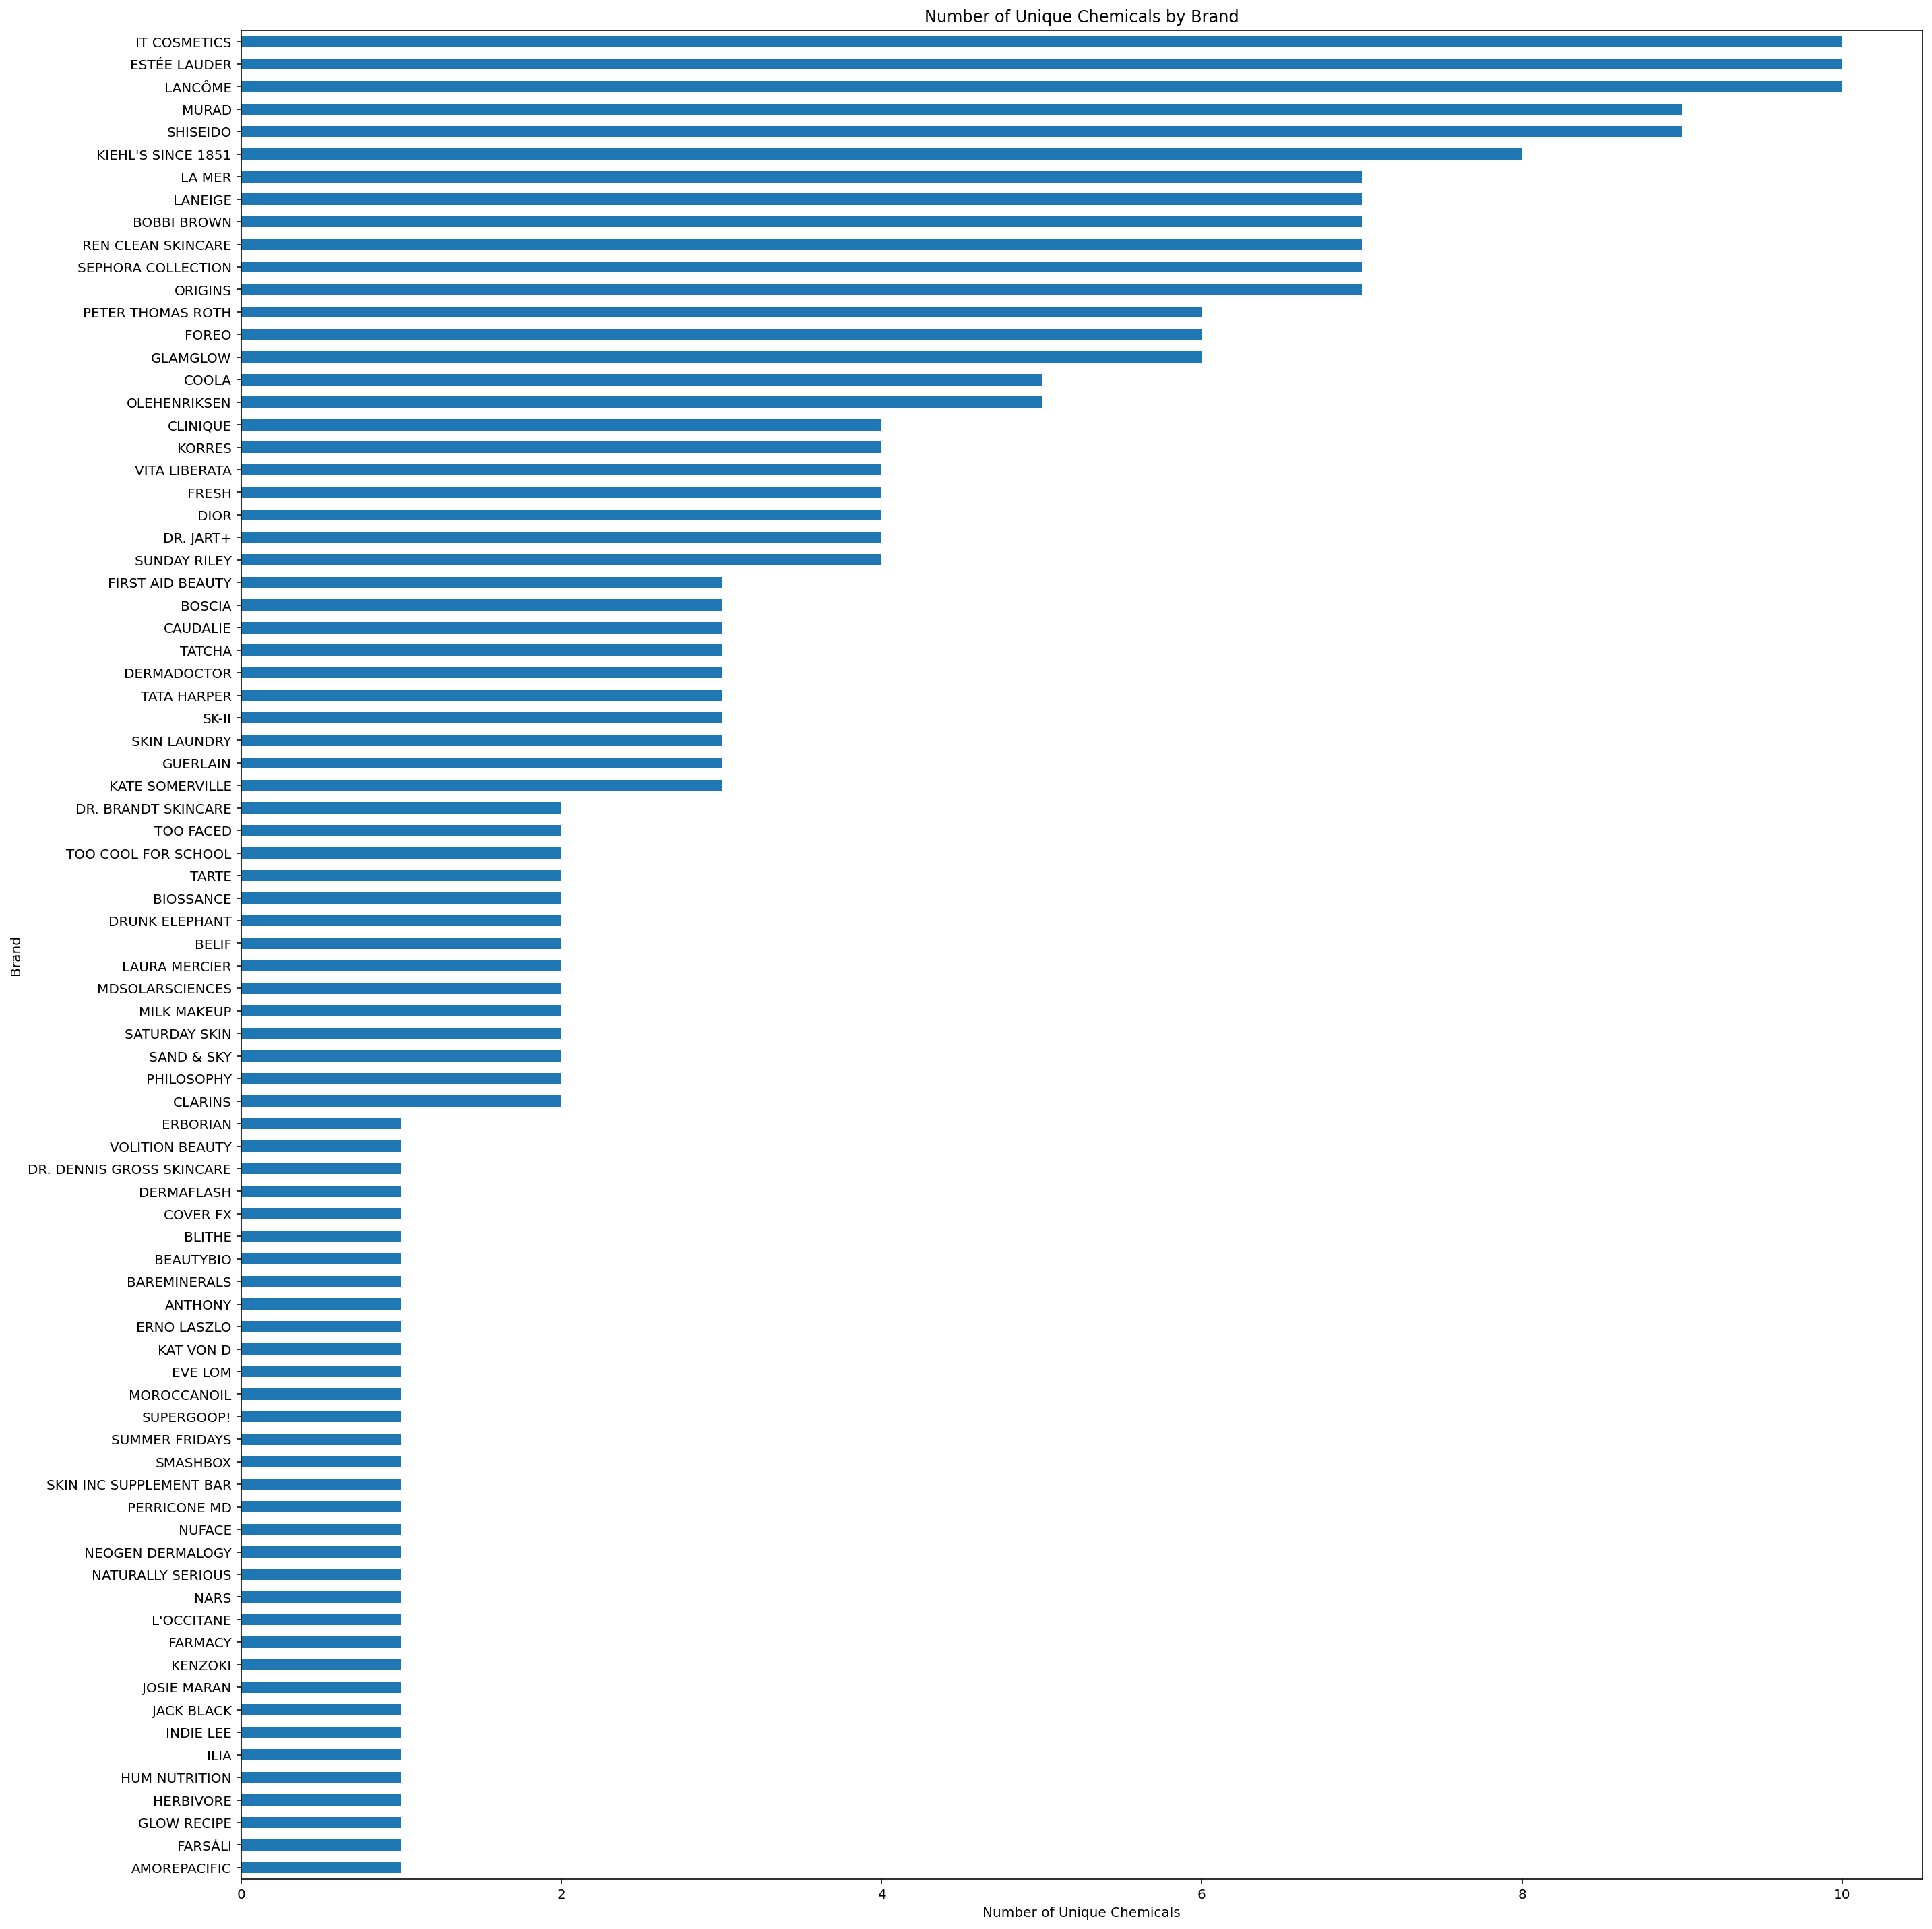

In [91]:
# number of unique chemicals per brand
chemicals_by_brand = balanced_df.groupby('brand')['ChemicalName'].nunique().sort_values()
plt.figure(figsize=(20, 20))
chemicals_by_brand.plot(kind='barh')
plt.xlabel('Number of Unique Chemicals')
plt.ylabel('Brand')
plt.title('Number of Unique Chemicals by Brand')
plt.tight_layout()
plt.show()

In [92]:
# pivot table to aggregate the binary values for each chemical and skin type combination
pivot_table = balanced_df.pivot_table(index='ChemicalName', 
                                values=['dry', 'normal', 'oily', 'sensitive'], 
                                aggfunc='sum')

<Figure size 1296x720 with 0 Axes>

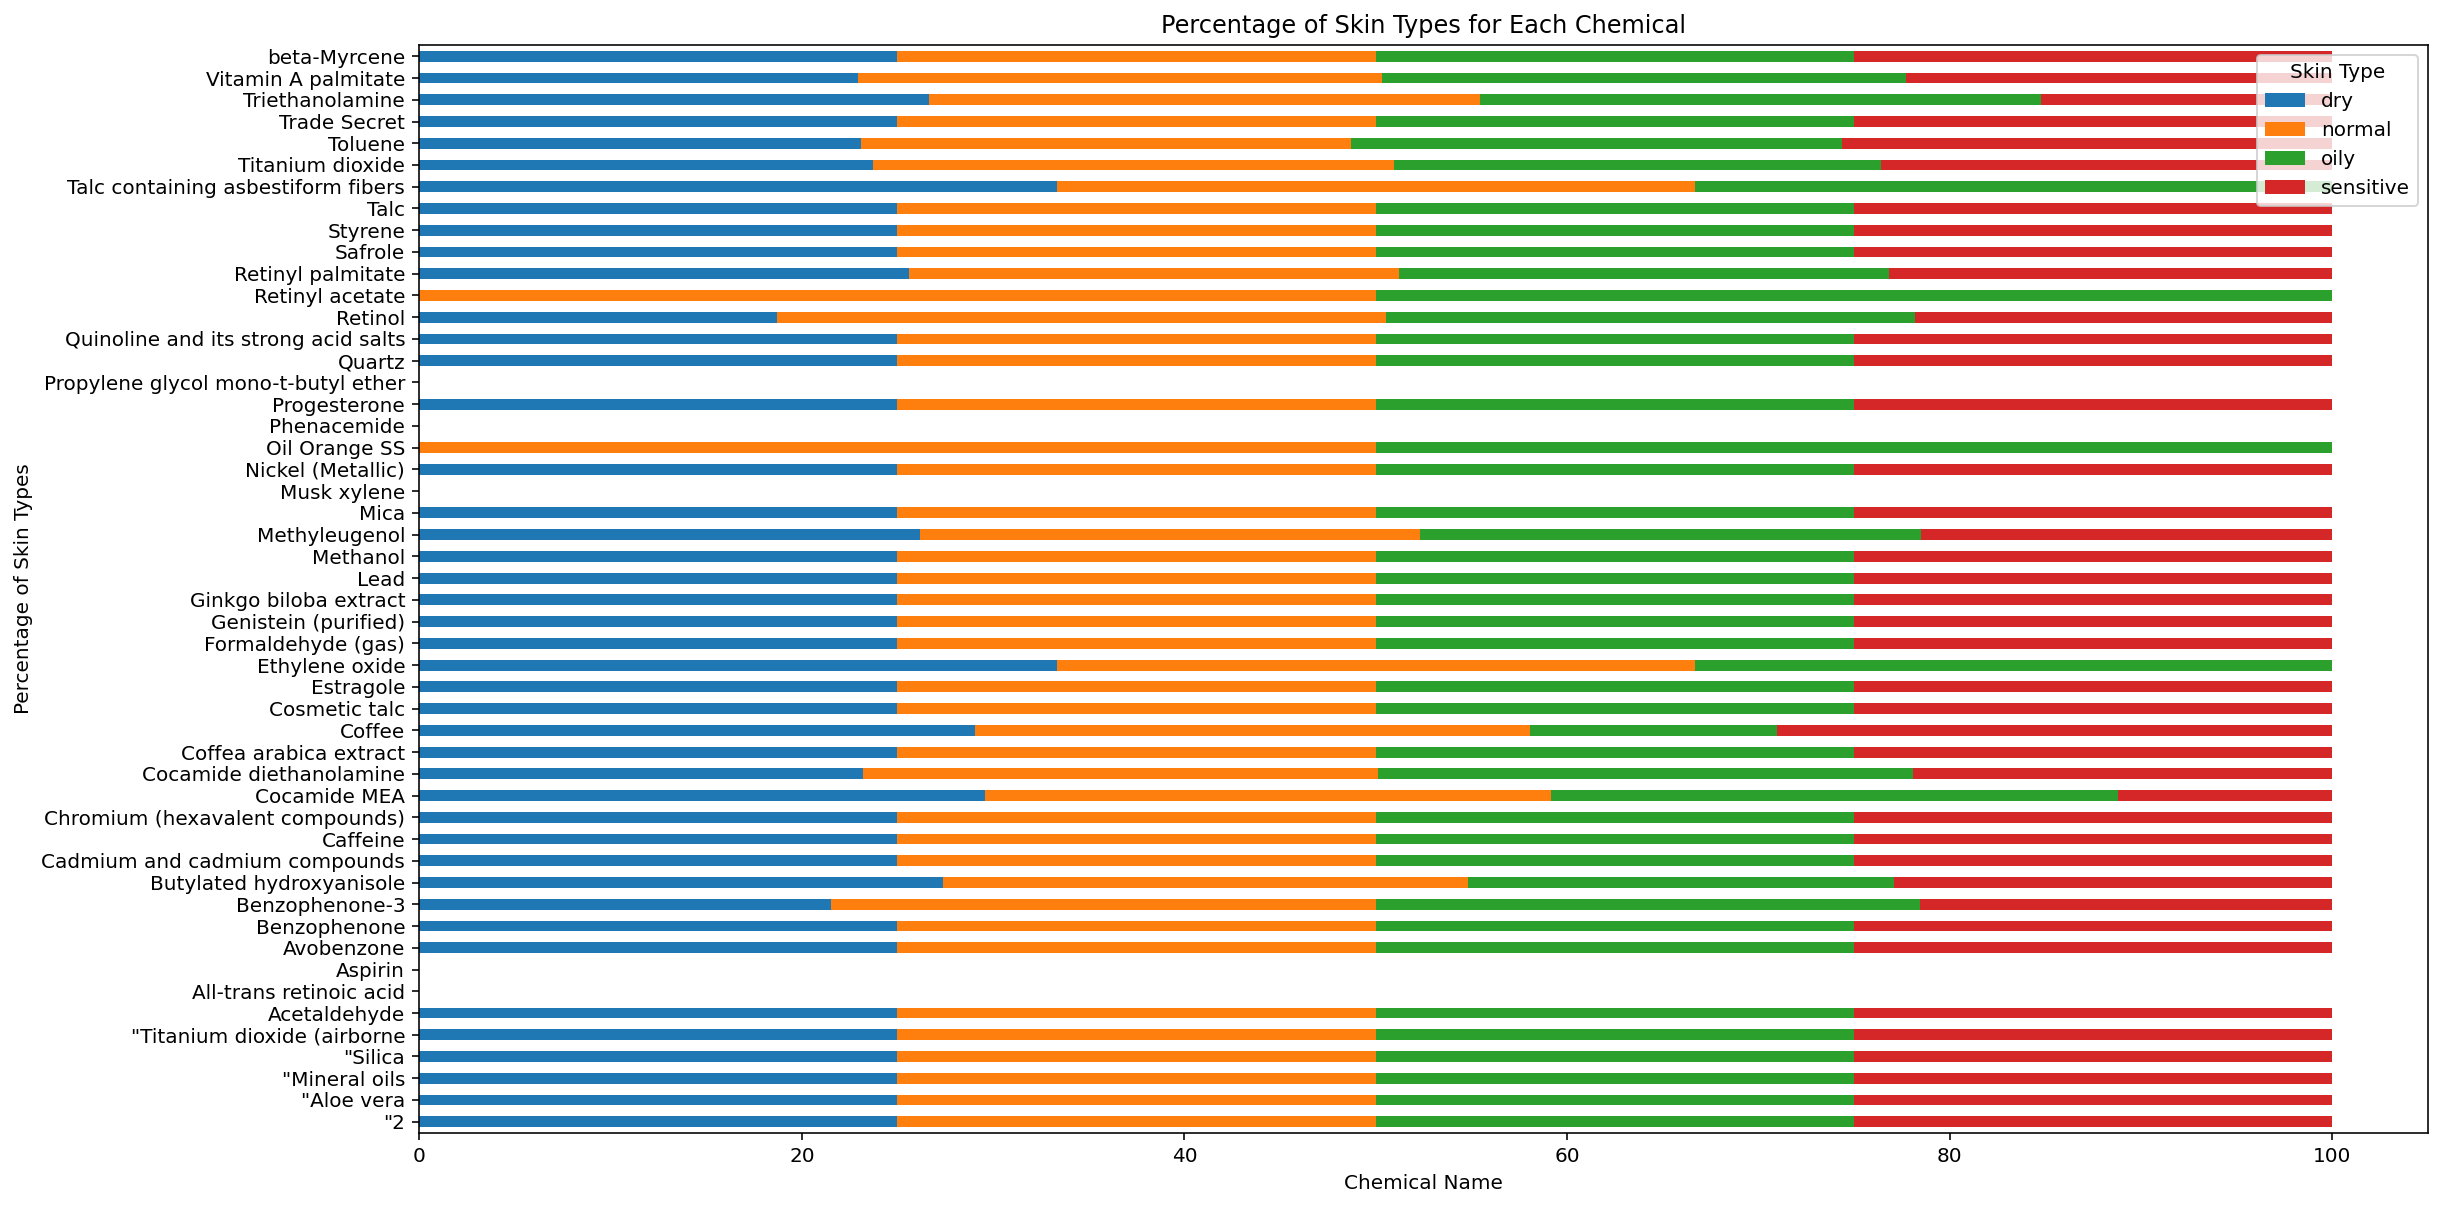

In [93]:
# calculate total number of chemicals per skin type
pivot_table['total'] = pivot_table.sum(axis=1)

# calculate percentage of each skin type for each chemical
for col in pivot_table.columns:
    pivot_table[col] = pivot_table[col] / pivot_table['total'] * 100
pivot_table.drop(columns='total', inplace=True)

# set figure size
plt.figure(figsize=(18, 10))

# plot % of skin types for each chemical 
pivot_table.plot(kind='barh', stacked=True, figsize=(18, 10))
plt.xlabel('Chemical Name')
plt.ylabel('Percentage of Skin Types')
plt.title('Percentage of Skin Types for Each Chemical')

plt.legend(title='Skin Type', loc='upper right')
plt.show();

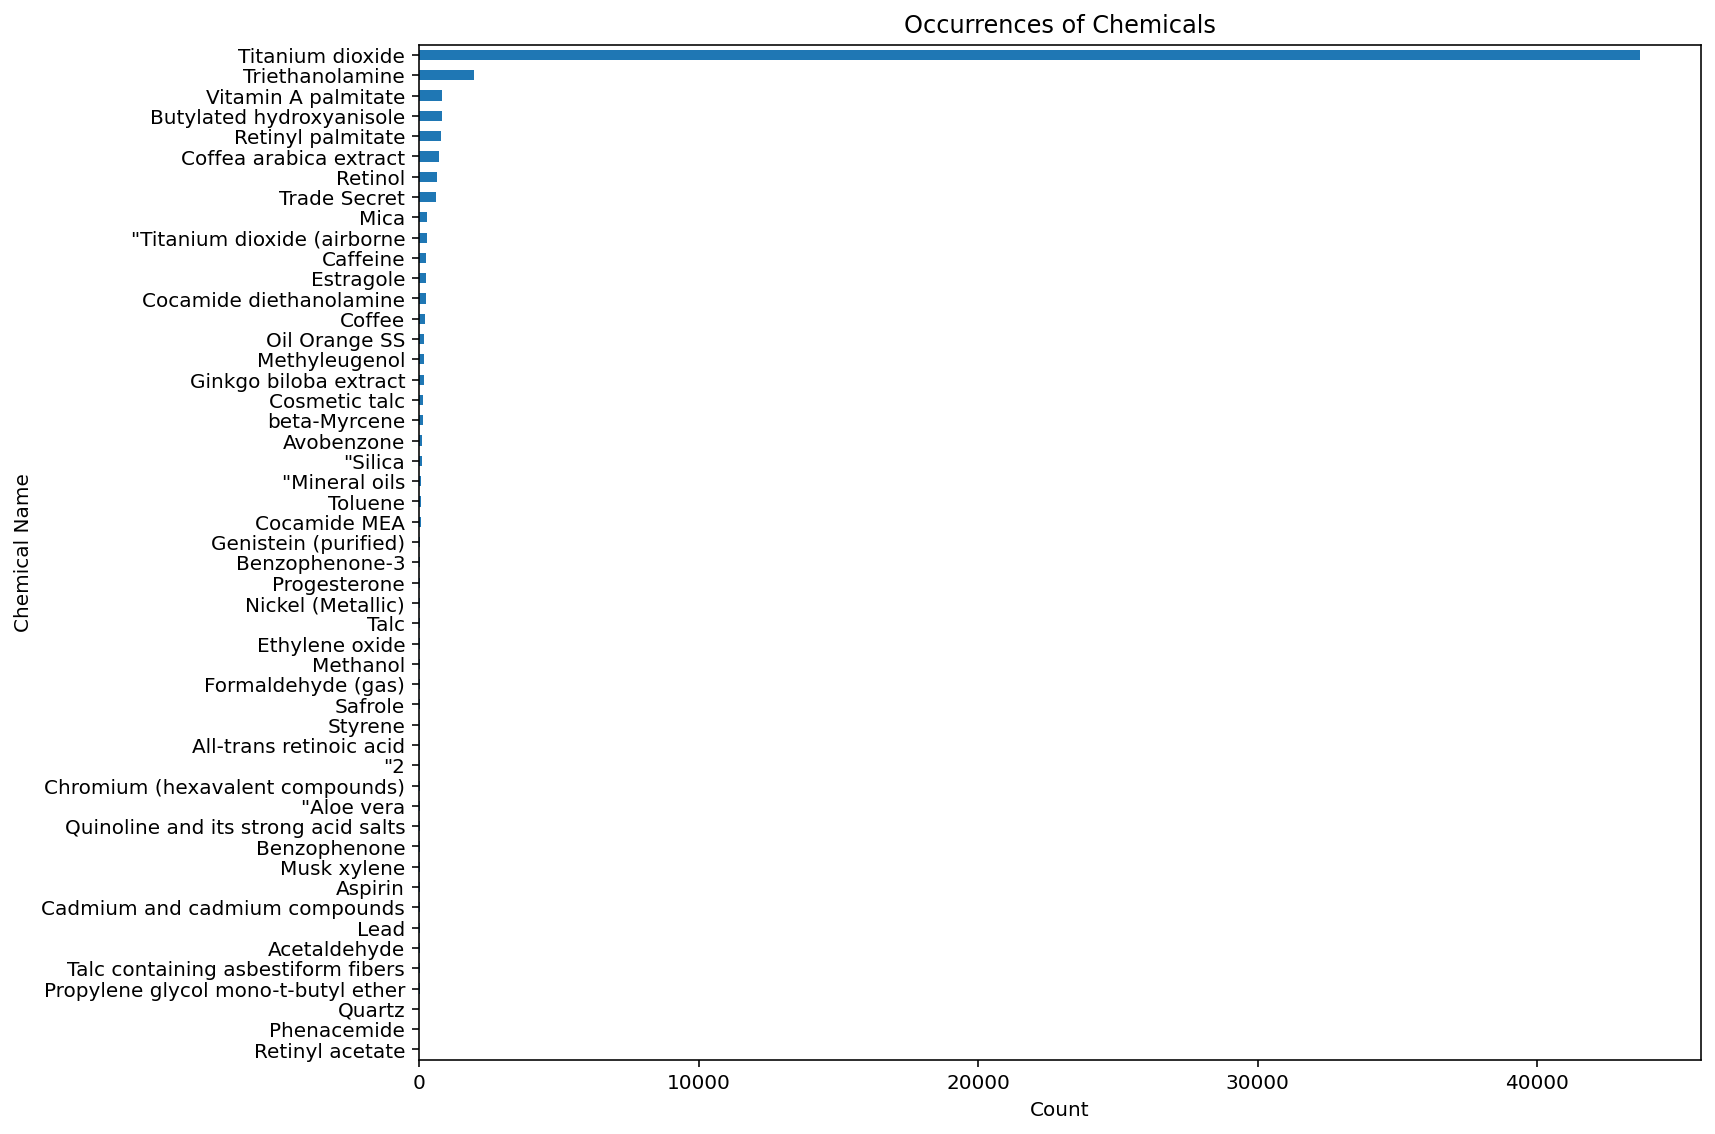

In [94]:
# count occurrences of each chemical
chemical_counts = balanced_df['ChemicalName'].value_counts()
chemical_counts_sorted = chemical_counts.sort_values(ascending=True)

# plot bar chart
plt.figure(figsize=(12, 8))
chemical_counts_sorted.plot(kind='barh')
plt.title('Occurrences of Chemicals')
plt.xlabel('Count')
plt.ylabel('Chemical Name')
plt.tight_layout()
plt.show()

In [95]:
# summary statistics of target column 'ordered'
balanced_df['ordered'].describe()

count    53325.000000
mean         0.900009
std          0.299990
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: ordered, dtype: float64

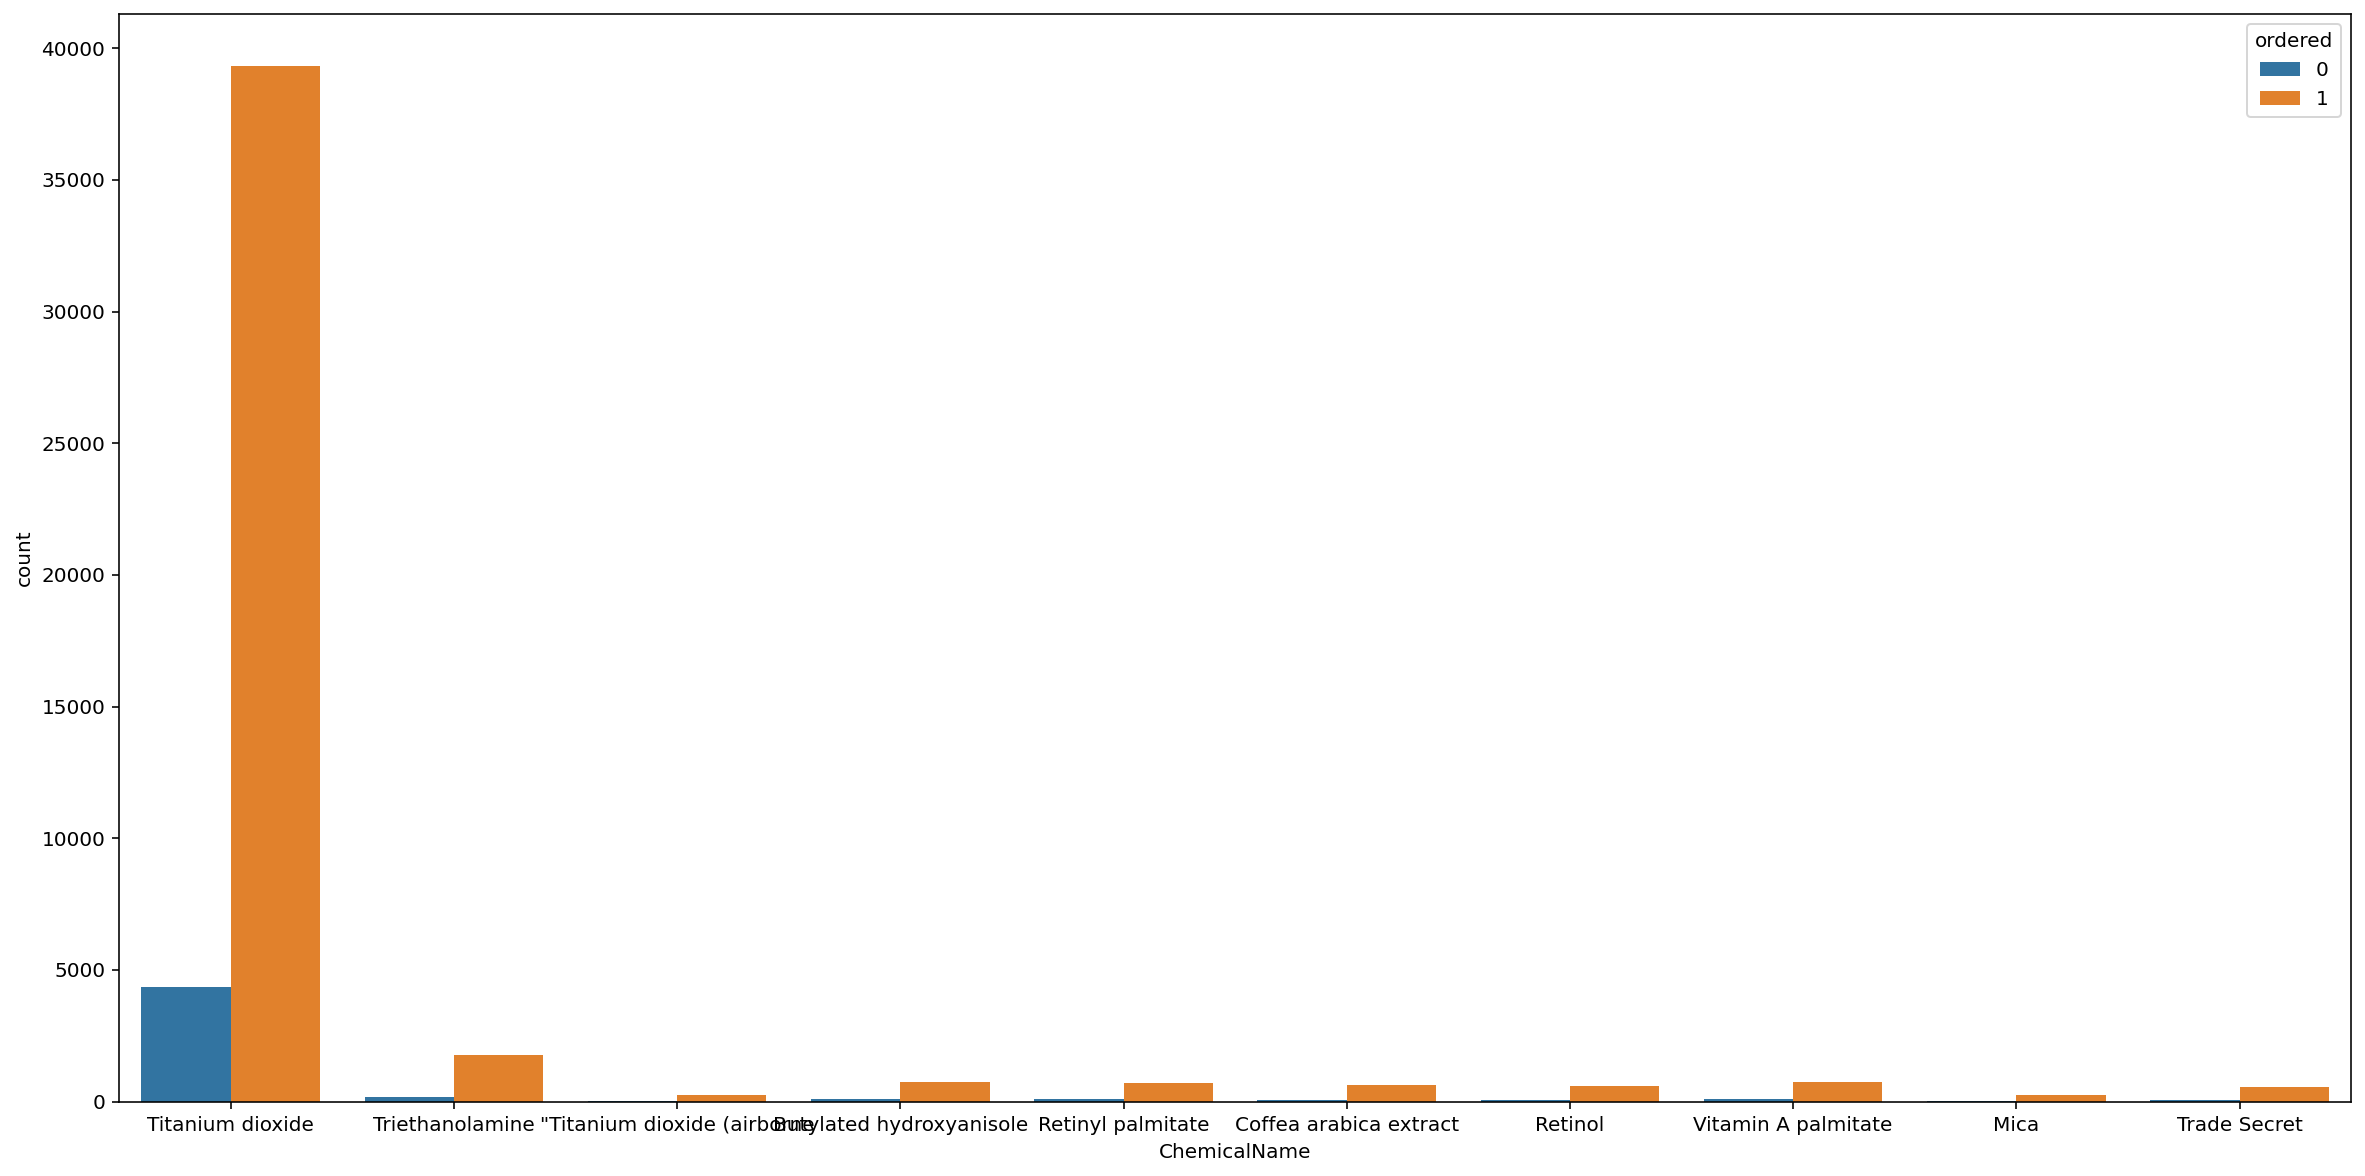

In [96]:
# create df for top chemicals + whether they were bought 
top_n_chemicals = balanced_df['ChemicalName'].value_counts().nlargest(10).index
top_n_df = balanced_df[balanced_df['ChemicalName'].isin(top_n_chemicals)]

# set figure
plt.figure(figsize=(20, 10))
sns.countplot(data=top_n_df, x="ChemicalName", hue="ordered")
plt.show()

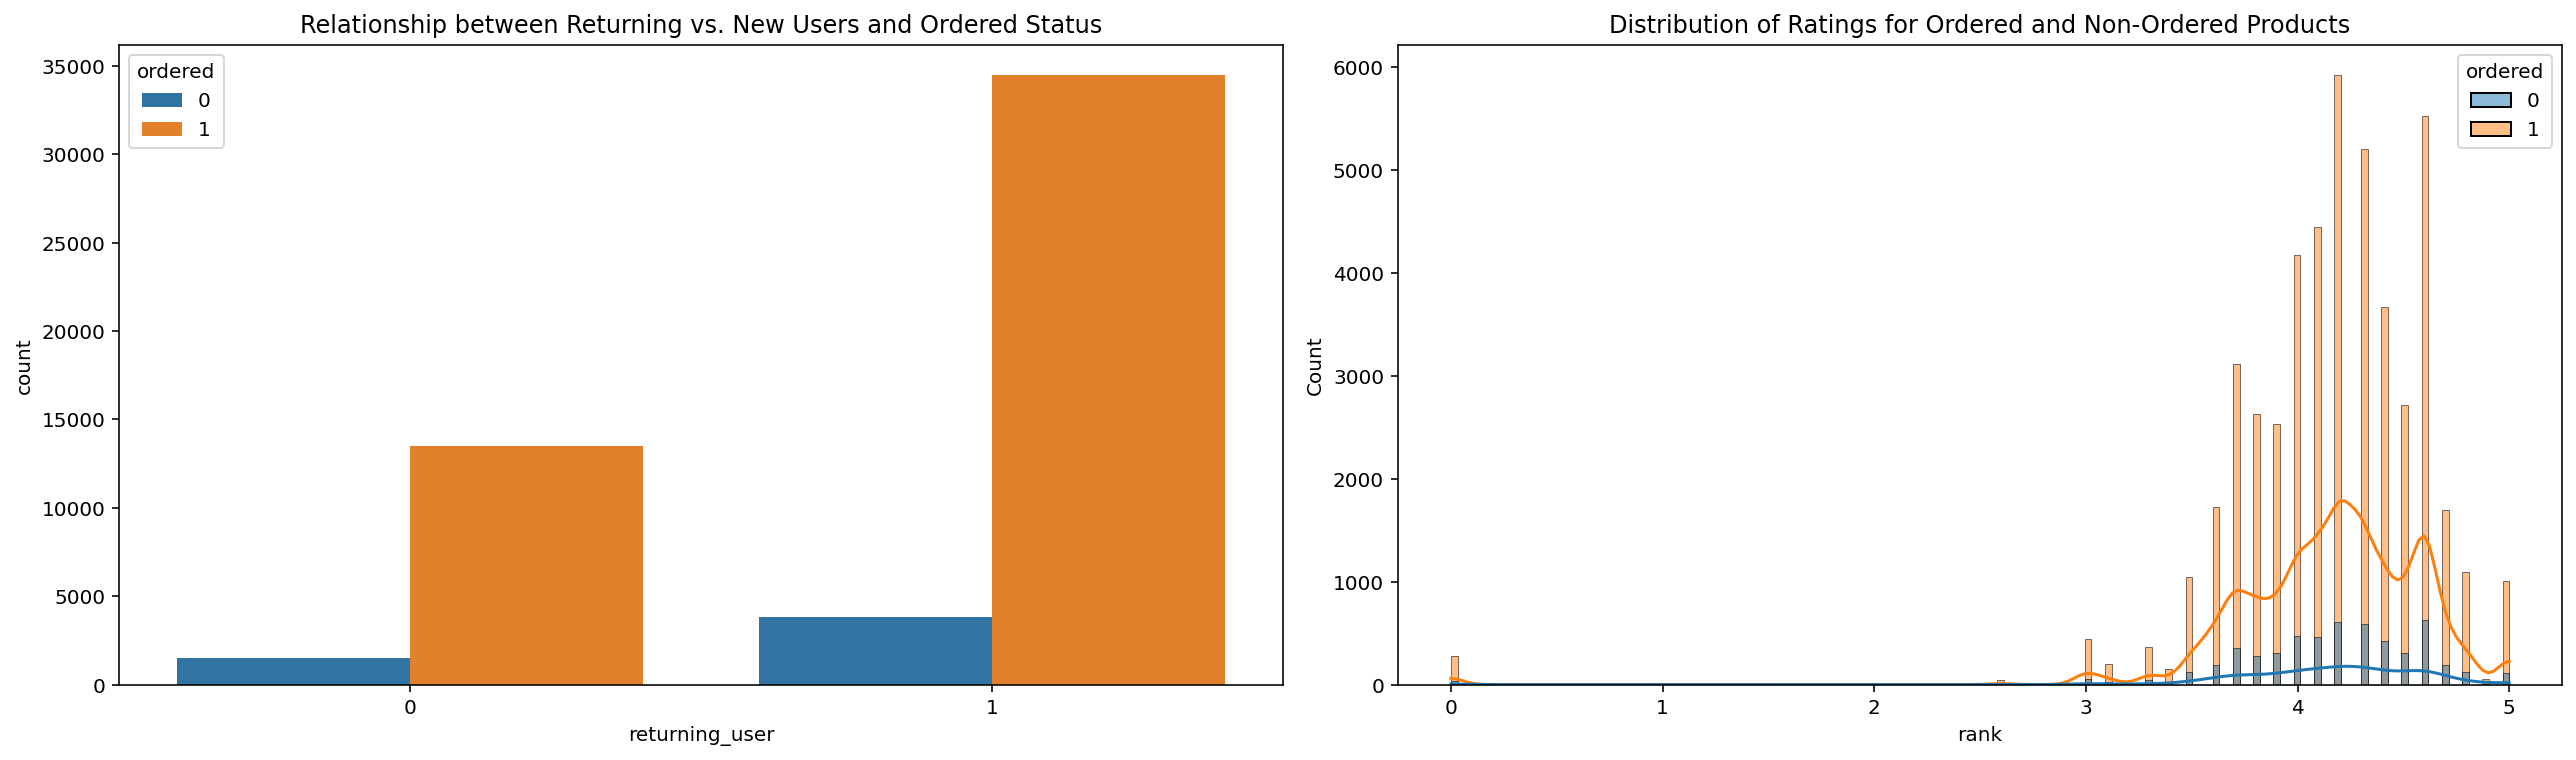

In [97]:
plt.figure(figsize=(18, 10))

# relationship between returning vs. new users and ordered status
plt.subplot(2, 2, 1)
sns.countplot(data=balanced_df, x='returning_user', hue='ordered')
plt.title('Relationship between Returning vs. New Users and Ordered Status')

# distribution of ratings for ordered and non-ordered products
plt.subplot(2, 2, 2)
sns.histplot(data=balanced_df, x='rank', hue='ordered', kde=True)
plt.title('Distribution of Ratings for Ordered and Non-Ordered Products')

plt.tight_layout()
plt.show()

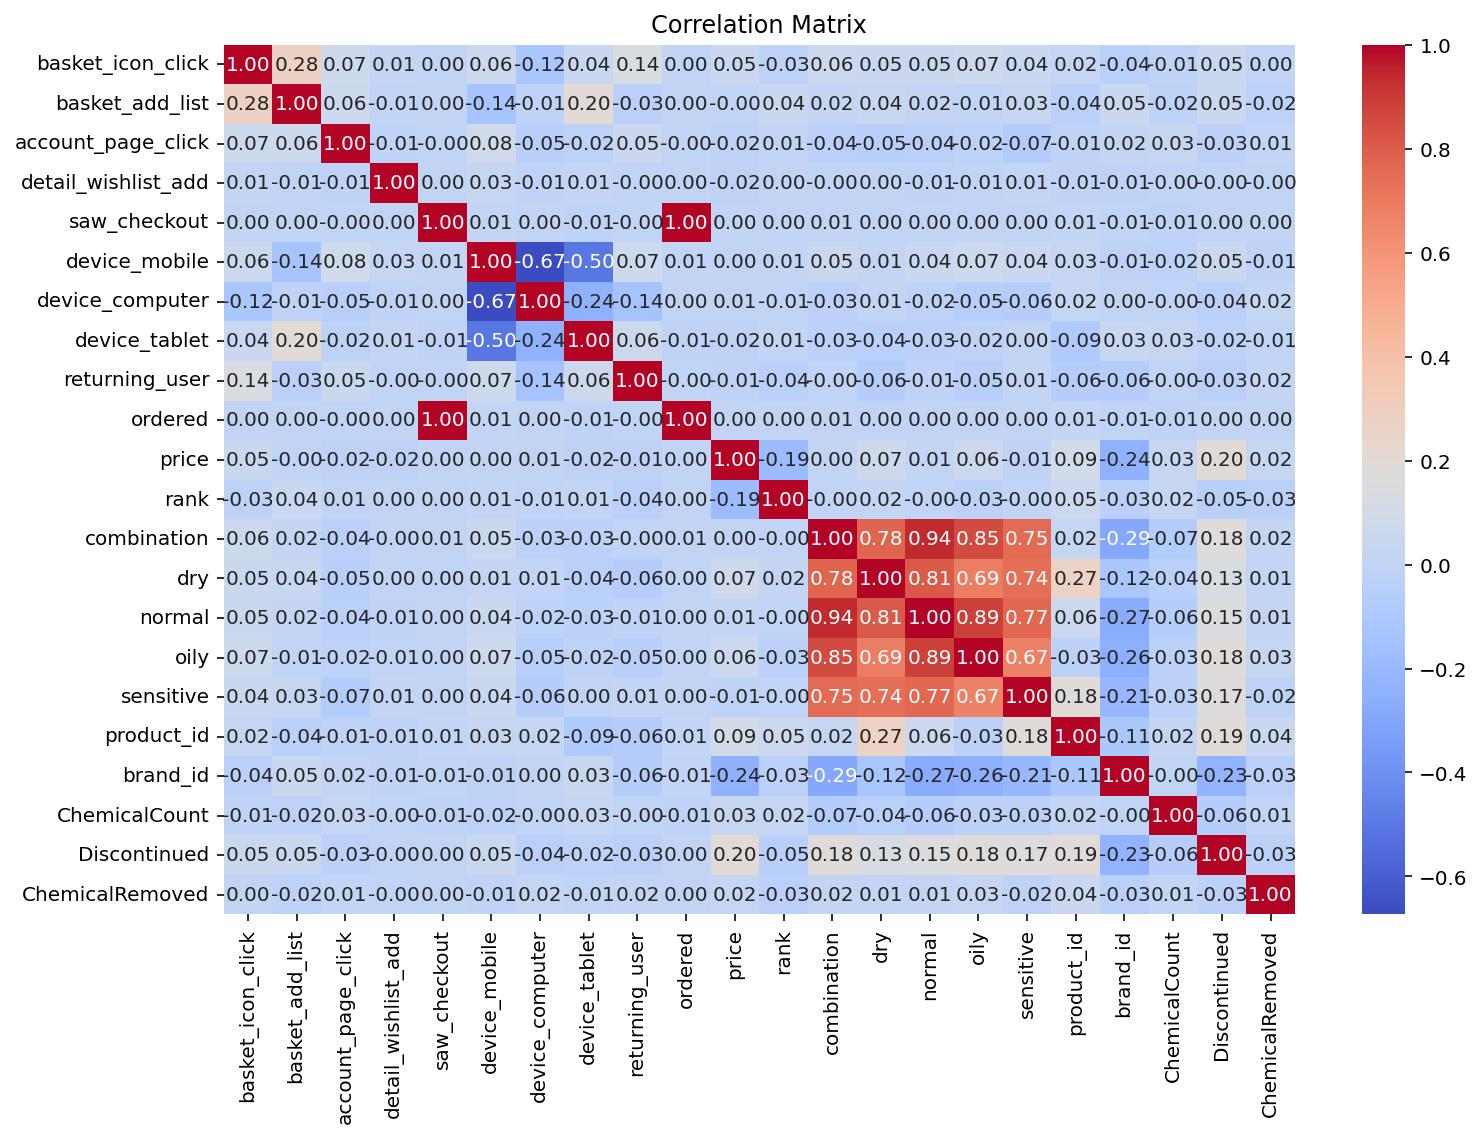

In [98]:
correlation_matrix = balanced_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Data Scrubbing 

#### Data Consistency

In [99]:
# Data consitency w/device columns 
inconsistent_records = balanced_df[(balanced_df['device_mobile'] + balanced_df['device_computer'] + balanced_df['device_tablet']) > 1]
print("Inconsistent records:", inconsistent_records)

Inconsistent records:                                     UserID  basket_icon_click  \
48337  d745-77b9d7c6-d745-4d64-84b8-565757                  0   
25213  9735-b70246ad-9735-433c-a7d7-605098                  1   
27707  13b0-4648c7a7-13b0-4967-a680-968619                  1   
40518  0725-99bdb41e-0725-4d69-b07b-166639                  1   
212    0546-ava6886d-0546-4774-a046-547739                  0   
...                                    ...                ...   
49080  57b5-10756521-57b5-41d0-9173-602649                  1   
206    0546-ava6886d-0546-4774-a046-547739                  0   
52251  ad87-0c841680-ad87-4c7a-879d-748367                  1   
161    0546-ava6886d-0546-4774-a046-547739                  0   
189    0546-ava6886d-0546-4774-a046-547739                  0   

       basket_add_list  account_page_click  detail_wishlist_add  saw_checkout  \
48337                0                   0                    0             1   
25213                1             

In [100]:
# drop inconcistent records - rows where the sum of device columns is greater than 1 (1049 rows were picked up to have suplicate values)
inconsistent_records_index = (balanced_df['device_mobile'] + balanced_df['device_computer'] + balanced_df['device_tablet']) > 1
balanced_df.drop(inconsistent_records_index.index[inconsistent_records_index], inplace=True)

In [101]:
balanced_df.shape #shape after duplicate values were dropped 

(52276, 30)

#### Data Type Conversion 

In [102]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52276 entries, 31078 to 15795
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               52276 non-null  object 
 1   basket_icon_click    52276 non-null  int64  
 2   basket_add_list      52276 non-null  int64  
 3   account_page_click   52276 non-null  int64  
 4   detail_wishlist_add  52276 non-null  int64  
 5   saw_checkout         52276 non-null  int64  
 6   device_mobile        52276 non-null  int64  
 7   device_computer      52276 non-null  int64  
 8   device_tablet        52276 non-null  int64  
 9   returning_user       52276 non-null  int64  
 10  ordered              52276 non-null  int64  
 11  label                52276 non-null  object 
 12  brand                52276 non-null  object 
 13  name                 52276 non-null  object 
 14  price                52276 non-null  float64
 15  rank                 52276 non-n

In [103]:
# convert Rank, Discontinued, and ChemicalRemoved, Dry to integer type
balanced_df['rank'] = balanced_df['rank'].astype(int)
balanced_df['Discontinued'] = balanced_df['Discontinued'].astype(int)
balanced_df['ChemicalRemoved'] = balanced_df['ChemicalRemoved'].astype(int)
balanced_df['dry'] = balanced_df['dry'].astype(int)

#### Outlier Detection 

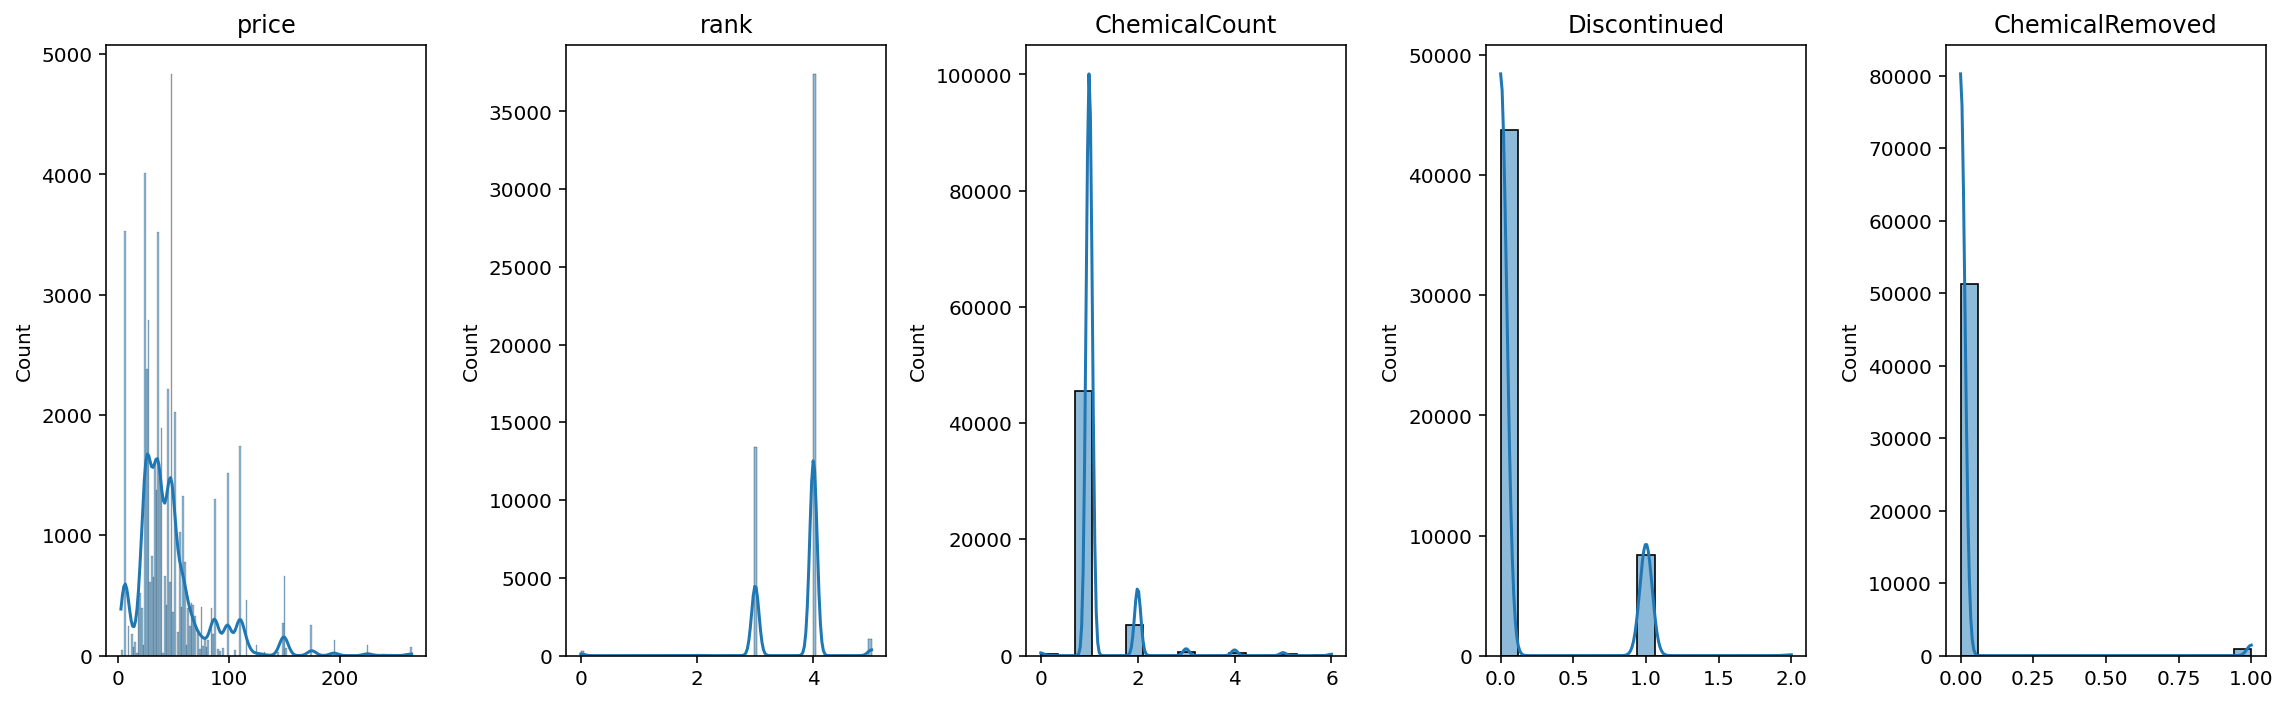

In [104]:
# visulaize potential outliers 
def visualize_distribution(balanced_df, columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(16, 5))
    for i, col in enumerate(columns):
        sns.histplot(balanced_df[col], ax=axes[i], kde=True)
        axes[i].set_title(col)
        axes[i].set_xlabel('')
    plt.tight_layout()
    plt.show()

# define numerical columns for visualization
numerical_columns = ['price', 'rank', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved']
visualize_distribution(balanced_df, numerical_columns)

In [105]:
 balanced_df[numerical_columns].describe() #outliers will remain in the df 

,price,rank,ChemicalCount,Discontinued,ChemicalRemoved
count,52276.00000,52276.000000,52276.000000,52276.000000,52276.000000
mean,48.70277,3.738962,1.170308,0.163287,0.017695
std,33.52022,0.554929,0.560364,0.372723,0.131840
min,3.00000,0.000000,0.000000,0.000000,0.000000
25%,28.00000,3.000000,1.000000,0.000000,0.000000
50%,39.00000,4.000000,1.000000,0.000000,0.000000
75%,56.00000,4.000000,1.000000,0.000000,0.000000
max,265.00000,5.000000,6.000000,2.000000,1.000000


In [106]:
balanced_df['ChemicalCount'].value_counts() # inspect chemical count distribution 

1.0    45499
2.0     5248
3.0      539
4.0      447
5.0      231
0.0      208
6.0      104
Name: ChemicalCount, dtype: int64

#### Duplicate Values 

In [107]:
# check for duplicates
balanced_df.duplicated().sum() #original df is 52276 rows 

35263

In [108]:
duplicate_rows = balanced_df[balanced_df.duplicated()]
duplicate_rows.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
44611,9b77-915b4616-9b77-4av4-a5b8-18803,1,1,0,0,1,1,0,0,1,1,Sun protect,CLINIQUE,Superdefense SPF 20 Age Defense Moisturizer Co...,48.0,4,Avobenzone 3.00% - Octisalate 5.00%Water - But...,0,0,0,0,0,19,1371,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0,0
4772,b9d4-7d6d184b-b9d4-4386-8373-393384,1,0,0,0,1,0,0,1,1,1,Moisturizer,PETER THOMAS ROTH,Water Drench Hyaluronic Cloud Cream,52.0,4,Water- Glycerin- Cyclopentasiloxane- Dipropyle...,1,1,1,1,1,87,82,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,1,0
10593,5755-64d4d614-5755-4859-8368-678724,0,0,0,0,1,1,0,0,1,1,Cleanser,MILK MAKEUP,Matcha Toner,26.0,3,Water- butylene glycol- Bis-PEG-18 methyl ethe...,1,1,1,1,1,73,481,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0,0
46177,653d-164950c6-653d-467d-a9bb-403392,1,1,0,0,1,1,0,0,1,1,Sun protect,MDSOLARSCIENCES,MD Crème Mineral Beauty Balm Broad Spectrum SP...,39.0,4,Dimethicone- Dimethicone Crosspolymer- Capryli...,1,1,1,1,1,72,1443,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0,0
50193,b97d-822dd60b-b97d-4236-bd87-270231,0,0,0,0,1,0,0,1,1,1,Sun protect,FARMACY,Green Screen Daily Environmental Protector Bro...,36.0,4,Water- Ethyl Macadamiate- Cyclopentasiloxane- ...,1,1,1,1,1,35,1325,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0,0


In [109]:
duplicate_rows['UserID'].value_counts() #UserID has duplicate values, rows will be dropped

5642-c776771a-5642-4976-ab38-433170    255
0259-7260bd67-0259-4156-aad9-475096    254
7270-19b97296-7270-474c-8c91-805757    254
b546-1695b9d0-b546-4629-a7bd-747284    253
6777-d3c524d9-6777-4979-ad0b-185904    253
                                      ... 
7592-3b5a7775-7592-46d2-83b7-124807      1
1db3-c095751e-1db3-4a3a-8c70-828940      1
78a7-3847aa0c-78a7-40a8-b859-166586      1
53a7-b6771682-53a7-b1a5-b133-384169      1
6ad6-4c5a0756-6ad6-4911-a674-726901      1
Name: UserID, Length: 779, dtype: int64

In [110]:
# remove duplicate rows 
clean_df = balanced_df.drop_duplicates()
clean_df = clean_df.reset_index(drop=True)

In [111]:
# inspect df 
print('Number of Rows:', clean_df.shape[0])
print('Number of Columns:', clean_df.shape[1], '\n')

clean_df.info()

Number of Rows: 17013
Number of Columns: 30 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17013 entries, 0 to 17012
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               17013 non-null  object 
 1   basket_icon_click    17013 non-null  int64  
 2   basket_add_list      17013 non-null  int64  
 3   account_page_click   17013 non-null  int64  
 4   detail_wishlist_add  17013 non-null  int64  
 5   saw_checkout         17013 non-null  int64  
 6   device_mobile        17013 non-null  int64  
 7   device_computer      17013 non-null  int64  
 8   device_tablet        17013 non-null  int64  
 9   returning_user       17013 non-null  int64  
 10  ordered              17013 non-null  int64  
 11  label                17013 non-null  object 
 12  brand                17013 non-null  object 
 13  name                 17013 non-null  object 
 14  price                17013 non-null  flo

In [112]:
clean_df.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
0,c7d7-ac1e8977-c7d7-4db0-a657-307042,1,0,0,0,1,1,0,0,1,1,Moisturizer,AMOREPACIFIC,FUTURE RESPONSE Age Defense Creme,195.0,4,Camellia Sinensis Leaf Water- Butylene Glycol-...,1,1,1,1,1,1,79,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0,0
1,065c-1c33b077-065c-4382-b179-268024,1,0,0,0,1,1,0,0,1,1,Moisturizer,LANCÔME,Rénergie Lift Multi-Action Sunscreen Broad Spe...,99.0,3,Water- Dimethicone- Glycerin- Hydrogenated Pol...,1,1,1,1,1,66,249,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,2.0,0,0
2,7765-29ab1200-7765-498d-8763-888156,1,0,0,0,1,0,1,0,1,1,Moisturizer,PETER THOMAS ROTH,Water Drench Hyaluronic Cloud Cream,52.0,4,Water- Glycerin- Cyclopentasiloxane- Dipropyle...,1,1,1,1,1,87,82,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0,0
3,5642-c776771a-5642-4976-ab38-433170,1,1,0,0,1,0,0,1,1,1,Cleanser,CAUDALIE,Vinopure Natural Salicylic Acid Pore Minimizin...,28.0,3,*Plant origin.,1,0,1,1,1,15,352,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0,0
4,cadb-546776b3-cadb-4130-8423-697980,0,0,0,0,0,0,1,0,1,0,Treatment,ESTÉE LAUDER,Idealist Pore Minimizing Skin Refinisher,86.0,4,Idealist Extra Pore Min Skin Refin Division: E...,0,0,0,0,0,33,695,Skin Care Products,Skin Bleaching (making a cosmetic claim),Triethanolamine,2.0,0,0


### Feature Selection 

#### Chi-Square 

We will use chi-square to identify columns with high p-values and remove the redundant/irrelevant columns. 

In [113]:
# define target column to be analyzed for assocation 
target_column = 'ordered'

# create an empty array to store the results of chi-square test
chi_results = []

# iterate through all columns (excluding the target column)
for column in clean_df.columns:
    if column != target_column:
        # create a contingency table for the independent and target variable
        cross_tab = pd.crosstab(index=clean_df[column], columns=clean_df[target_column])
        # perform chi-square test
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        # append results to the list
        chi_results.append({
            'Variable': column,
            'Chi-Square Value': chi2,
            'P-Value': p,
            'Degrees of Freedom': dof
        })


# display results in a df 
chi_df = pd.DataFrame(chi_results)
chi_df

,Variable,Chi-Square Value,P-Value,Degrees of Freedom
0,UserID,804.430567,9.999998e-01,1018
1,basket_icon_click,0.024996,8.743760e-01,1
2,basket_add_list,0.078203,7.797481e-01,1
3,account_page_click,0.159475,6.896402e-01,1
4,detail_wishlist_add,0.393116,5.306659e-01,1
5,saw_checkout,17006.346316,0.000000e+00,1
6,device_mobile,0.128983,7.194892e-01,1
7,device_computer,0.050629,8.219716e-01,1
8,device_tablet,0.594495,4.406861e-01,1
9,returning_user,2.016101,1.556383e-01,1


In [114]:
# drop redundant columns such as userid, product_id, and brand_id and those identified with non-signifcant p-values
clean_df.drop(['UserID', 'name', 'brand_id', 'PrimaryCategory', 'SubCategory', 'ingredients', 
               'basket_icon_click', 'basket_add_list', 'ChemicalRemoved'], axis=1, inplace=True)

#### Variance Inflation Factor (VIF)

In [115]:
X_numeric = clean_df.select_dtypes(include=['float64', 'int64'])

# create a df for VIF values
vif = pd.DataFrame()
vif["Variable"] = X_numeric.columns

# calculate/store VIF values for each numeric variable
vif["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print(vif)

/opt/conda/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


               Variable        VIF
0    account_page_click   1.019289
1   detail_wishlist_add   1.001921
2          saw_checkout        inf
3         device_mobile  41.328899
4       device_computer  16.724288
5         device_tablet  11.557566
6        returning_user   1.031471
7               ordered        inf
8                 price   1.046892
9                  rank   1.073921
10          combination   7.457329
11                  dry   5.708166
12               normal  13.375718
13                 oily   6.293062
14            sensitive   3.295815
15           product_id   1.128138
16        ChemicalCount   1.033043
17         Discontinued   1.069452


It's recommended to drop variables with high VIF values (>10) as they indicate significant multicollinearity. The following columns will be dropped: device_mobile, device_computer, device_tablet. 

In [116]:
# drop specified columns
clean_df.drop(['device_mobile', 'device_computer', 'device_tablet'], axis=1, inplace=True)

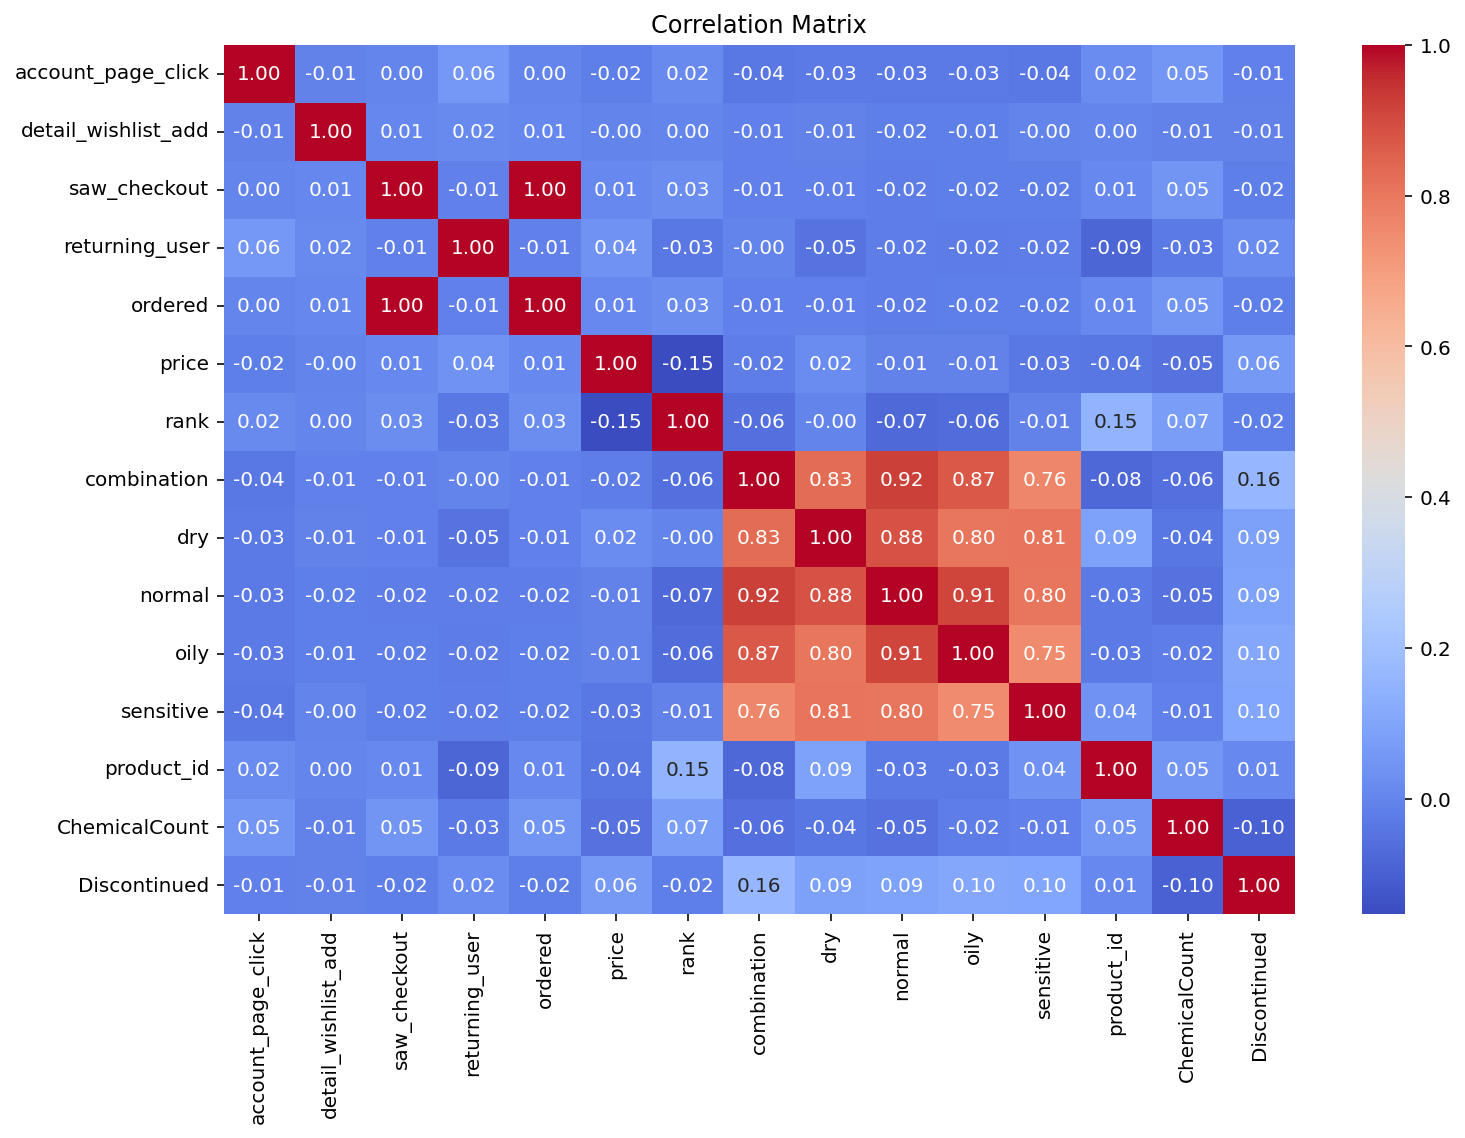

In [117]:
# create correlation matrix with reduced df 
correlation_matrix = clean_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [118]:
# correlation bewteen ordered and other variables 
ordered_correlation = correlation_matrix['ordered']
ordered_correlation

account_page_click     0.003546
detail_wishlist_add    0.006131
saw_checkout           1.000000
returning_user        -0.011051
ordered                1.000000
price                  0.009770
rank                   0.025794
combination           -0.010833
dry                   -0.010957
normal                -0.019972
oily                  -0.015506
sensitive             -0.017475
product_id             0.008999
ChemicalCount          0.045009
Discontinued          -0.016025
Name: ordered, dtype: float64

### Feature Transformation

In [119]:
# one hot encode categorical variables
cat_col = ["label", "brand", "ChemicalName", "rank"]
clean_df['ChemicalName'] = clean_df['ChemicalName'].str.replace('"', '')
encoded_df = pd.get_dummies(clean_df, columns=cat_col)

In [120]:
encoded_df.head()

,account_page_click,detail_wishlist_add,saw_checkout,returning_user,ordered,price,combination,dry,normal,oily,sensitive,product_id,ChemicalCount,Discontinued,label_Cleanser,label_Eye cream,label_Face Mask,label_Moisturizer,label_Sun protect,label_Treatment,brand_AMOREPACIFIC,brand_ANTHONY,brand_BAREMINERALS,brand_BEAUTYBIO,brand_BELIF,brand_BIOSSANCE,brand_BLITHE,brand_BOBBI BROWN,brand_BOSCIA,brand_CAUDALIE,brand_CLARINS,brand_CLINIQUE,brand_COOLA,brand_COVER FX,brand_DERMADOCTOR,brand_DERMAFLASH,brand_DIOR,brand_DR. BRANDT SKINCARE,brand_DR. DENNIS GROSS SKINCARE,brand_DR. JART+,brand_DRUNK ELEPHANT,brand_ERBORIAN,brand_ERNO LASZLO,brand_ESTÉE LAUDER,brand_EVE LOM,brand_FARMACY,brand_FARSÁLI,brand_FIRST AID BEAUTY,brand_FOREO,brand_FRESH,brand_GLAMGLOW,brand_GLOW RECIPE,brand_GUERLAIN,brand_HERBIVORE,brand_HUM NUTRITION,brand_ILIA,brand_INDIE LEE,brand_IT COSMETICS,brand_JACK BLACK,brand_JOSIE MARAN,brand_KAT VON D,brand_KATE SOMERVILLE,brand_KENZOKI,brand_KIEHL'S SINCE 1851,brand_KORRES,brand_L'OCCITANE,brand_LA MER,brand_LANCÔME,brand_LANEIGE,brand_LAURA MERCIER,brand_MDSOLARSCIENCES,brand_MILK MAKEUP,brand_MOROCCANOIL,brand_MURAD,brand_NARS,brand_NATURALLY SERIOUS,brand_NEOGEN DERMALOGY,brand_NUFACE,brand_OLEHENRIKSEN,brand_ORIGINS,brand_PERRICONE MD,brand_PETER THOMAS ROTH,brand_PHILOSOPHY,brand_REN CLEAN SKINCARE,brand_SAND & SKY,brand_SATURDAY SKIN,brand_SEPHORA COLLECTION,brand_SHISEIDO,brand_SK-II,brand_SKIN INC SUPPLEMENT BAR,brand_SKIN LAUNDRY,brand_SMASHBOX,brand_SUMMER FRIDAYS,brand_SUNDAY RILEY,brand_SUPERGOOP!,brand_TARTE,brand_TATA HARPER,brand_TATCHA,brand_TOO COOL FOR SCHOOL,brand_TOO FACED,brand_VITA LIBERATA,brand_VOLITION BEAUTY,ChemicalName_2,ChemicalName_Acetaldehyde,ChemicalName_All-trans retinoic acid,ChemicalName_Aloe vera,ChemicalName_Aspirin,ChemicalName_Avobenzone,ChemicalName_Benzophenone,ChemicalName_Benzophenone-3,ChemicalName_Butylated hydroxyanisole,ChemicalName_Cadmium and cadmium compounds,ChemicalName_Caffeine,ChemicalName_Chromium (hexavalent compounds),ChemicalName_Cocamide MEA,ChemicalName_Cocamide diethanolamine,ChemicalName_Coffea arabica extract,ChemicalName_Coffee,ChemicalName_Cosmetic talc,ChemicalName_Estragole,ChemicalName_Ethylene oxide,ChemicalName_Formaldehyde (gas),ChemicalName_Genistein (purified),ChemicalName_Ginkgo biloba extract,ChemicalName_Lead,ChemicalName_Methanol,ChemicalName_Methyleugenol,ChemicalName_Mica,ChemicalName_Mineral oils,ChemicalName_Musk xylene,ChemicalName_Nickel (Metallic),ChemicalName_Oil Orange SS,ChemicalName_Phenacemide,ChemicalName_Progesterone,ChemicalName_Propylene glycol mono-t-butyl ether,ChemicalName_Quartz,ChemicalName_Quinoline and its strong acid salts,ChemicalName_Retinol,ChemicalName_Retinyl acetate,ChemicalName_Retinyl palmitate,ChemicalName_Safrole,ChemicalName_Silica,ChemicalName_Styrene,ChemicalName_Talc,ChemicalName_Talc containing asbestiform fibers,ChemicalName_Titanium dioxide,ChemicalName_Titanium dioxide (airborne,ChemicalName_Toluene,ChemicalName_Trade Secret,ChemicalName_Triethanolamine,ChemicalName_Vitamin A palmitate,ChemicalName_beta-Myrcene,rank_0,rank_2,rank_3,rank_4,rank_5
0,0,0,1,1,1,195.0,1,1,1,1,1,1,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,1,99.0,1,1,1,1,1,66,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,1,1,52.0,1,1,1,1,1,87,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [121]:
encoded_df.shape

(17013, 157)

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [123]:
# create a copy of encoded_df before applying PCA 
pca_df = encoded_df.copy()

In [124]:
# standardize the data
scaler = StandardScaler()
# fit and transform data using scaler 
df_standardized = scaler.fit_transform(pca_df)

In [125]:
# apply PCA
pca = PCA()
pca.fit(df_standardized)

# calculate the cumulative explained variance ratio
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

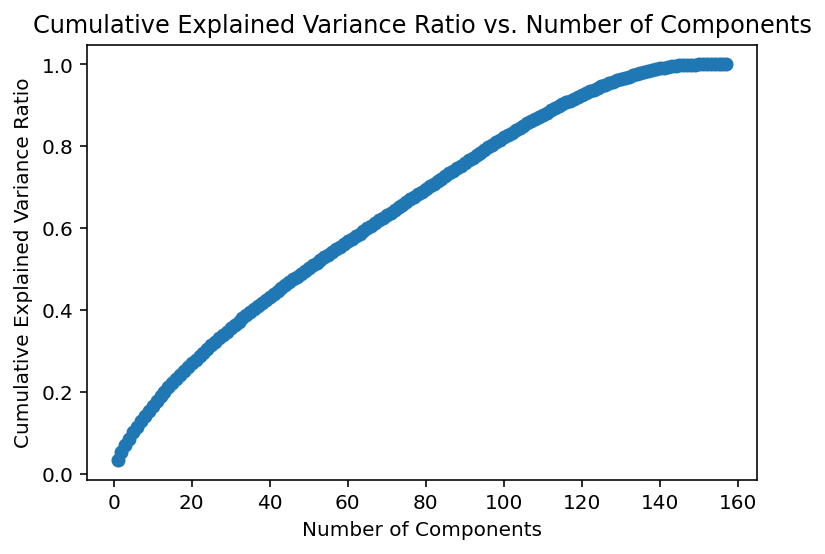

In [126]:
# plot cumulative explained variance ratio
plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.show()

In [127]:
# find the number of components that fall within 80% to 90% cumulative explained variance
target_variance_range = (0.80, 0.90)

# use NumPy to find the index of the first component within the specified variance range
target_components = np.where((explained_variance_ratio_cumulative >= target_variance_range[0]) &
                             (explained_variance_ratio_cumulative <= target_variance_range[1]))[0][0] + 1

print("Ideal number of components within 80% to 90% variance range:", target_components)

Ideal number of components within 80% to 90% variance range: 97


In [128]:
# extract target variable
y = encoded_df['ordered']
X = encoded_df.drop(columns=['ordered'])

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply PCA
pca = PCA(n_components=97)  
X_pca = pca.fit_transform(X_scaled)

In [129]:
# concatenate transformed features with target variable
pca_df= pd.DataFrame(X_pca, columns=[f'pca_{i}' for i in range(X_pca.shape[1])])
pca_df['ordered'] = y.values

In [130]:
pca_df.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,ordered
0,1.586080,1.894142,2.348543,2.034842,-0.517700,0.414077,0.919259,-0.321224,2.333304,-1.981005,2.023623,-1.158085,-0.846205,0.680622,0.700664,0.176351,-0.499823,-0.168647,1.492984,-0.448273,0.525734,-0.510882,-0.986078,0.037466,-0.137667,-0.390073,0.847280,-1.978383,0.045367,-0.276284,0.698353,-0.775763,-0.490199,0.206171,-0.066425,0.202148,0.200325,-1.672201,1.443391,1.599081,-0.120343,-3.442399,1.613341,-1.755469,-0.116194,-0.871109,0.098781,-2.208920,-2.514742,-1.916205,-2.784457,-0.484813,-0.613661,1.348103,-1.448718,1.718070,2.413896,0.500700,1.260586,0.948980,-2.651875,-2.024911,-2.282283,-2.059307,-0.282899,0.113202,-0.451058,0.366294,0.129669,0.288704,0.183459,-1.034038,0.615614,0.476752,-0.391162,-0.767716,-0.886519,-0.182542,-0.004755,1.817361,-0.183793,0.333171,-0.491382,-0.050141,2.349590,-1.654311,0.786033,0.586585,-0.579863,-0.297262,-1.060726,1.036666,-1.216002,-0.324059,0.163874,0.315904,1.045689,1
1,2.159596,2.027338,0.804239,0.029628,0.723839,-0.761202,-0.377132,-0.113535,0.259733,0.041936,2.191612,-1.505737,-0.905668,1.020698,1.310907,-1.279409,-0.762784,-0.355961,0.225220,0.328976,-0.038961,1.025490,0.722458,0.565281,-1.066029,0.658963,-0.458266,0.389908,0.189757,-0.036542,-0.277353,-1.018722,0.873264,0.098413,-0.194616,0.484802,0.169447,-0.605150,-0.033026,0.287870,-0.431251,0.302725,0.041019,0.075312,0.142316,-0.021962,-0.094696,-0.032948,0.119769,0.071619,0.156647,-0.183528,-0.098797,0.091538,-0.066621,-0.029284,0.086755,-0.064207,0.019911,0.004477,-0.014370,-0.093477,-0.013727,0.024580,-0.048511,-0.008592,0.022404,-0.021390,0.014844,0.035370,0.038782,0.014508,0.012693,0.027361,0.018503,-0.007163,0.205668,0.088598,0.048449,-0.031911,0.004075,0.062526,0.126718,0.194792,0.098819,-0.176273,0.012161,0.516592,0.032020,0.117752,-0.032552,0.310830,0.055153,-0.074538,0.895657,0.193785,-0.698600,1
2,1.613355,-0.185068,2.033863,0.159581,-1.761615,-0.824263,0.195465,-0.074079,0.520542,-0.439153,1.677236,-0.952802,0.110970,0.585590,0.091829,0.003838,0.596903,0.151033,0.047071,1.305789,-0.023993,-0.533437,-0.380537,-0.116716,0.499378,-0.090458,0.688498,-0.127893,-0.117499,-0.116732,0.199403,-0.616608,0.348069,-0.892096,1.289320,-0.349702,0.795995,0.131666,-0.509208,-0.440647,0.118813,0.421785,-0.097753,0.588247,-1.186045,-0.640655,-0.284388,0.649883,0.307016,-0.593929,0.249930,0.543148,-0.400691,0.121867,0.073352,0.200914,0.055881,-0.009354,0.085006,0.024846,-0.046229,0.075160,0.054926,-0.021325,0.010484,-0.011386,-0.008816,-0.024250,0.032424,0.008772,-0.017521,-0.010634,0.051638,-0.003871,-0.079135,-0.042602,0.070934,-0.005632,-0.180310,0.132370,-0.031880,0.089422,0.026508,0.003964,-0.298882,0.057386,0.329214,0.159762,0.474293,-0.627964,-0.125681,-0.602435,0.590969,-0.993824,0.010706,1.544531,0.208788,1
3,1.425139,2.168172,-1.941152,-1.701256,1.095465,0.358912,2.214795,-0.791568,0.051729,-1.010480,-0.363835,0.913444,0.352203,0.632868,1.737097,-1.073386,0.311096,0.127704,-1.034336,-0.085760,-0.592988,-0.846331,-0.662796,-0.572352,-0.088752,1.001170,-0.867266,-0.019994,0.277548,-0.978533,-2.143908,-0.292716,0.382408,-0.409593,0.222947,0.473220,0.839627,1.275866,-0.650001,-1.700192,-0.414202,-1.354164,1.753023,-0.658912,-0.826319,0.637725,0.413489,-0.291990,-0.704289,1.141213,0.030228,1.026240,-0.067278,-0.142580,0.858644,-0.223489,0.084177,0.055082,0.22

### Test, Validation, Train Split


train and test 95/5 **sagemaker

In [131]:
from sklearn.model_selection import train_test_split
# split 90% train and 10% holdout
df_train, df_test = train_test_split(pca_df, test_size=0.1, train_size=0.9, stratify=pca_df['ordered'])

In [132]:
# split data into features (X) and target variable (y)
X_train = df_train.drop(columns=['ordered'])
y_train = df_train['ordered']

# split the train data into train and holdout sets
X_train_split, X_holdout, y_train_split, y_holdout = train_test_split(X_train, y_train, test_size=0.1, train_size=0.9, stratify=y_train)

In [133]:
# create a SMOTE object
smote = SMOTE(random_state=42)

# apply SMOTE only on the training features
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_split, y_train_split)

In [134]:
resampled_train = pd.DataFrame(X_train_resampled, columns=X_train.columns)  # Assuming X_train has column names
resampled_train['ordered'] = y_train_resampled

In [135]:
resampled_train.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,ordered
0,1.878716,-2.367230,-0.665419,3.607974,1.150121,1.682292,-0.465790,0.022680,-2.612193,1.272253,-0.629750,-0.523350,0.765832,-0.500408,1.600808,2.289330,2.114834,0.815539,-0.599356,0.337525,1.948728,0.035609,-1.064933,-1.569786,-0.960717,1.856942,0.158855,0.933726,1.332963,0.476089,3.211460,0.866467,1.500695,0.464412,-1.570717,0.190837,1.319103,-1.334209,0.105116,-1.495422,0.878391,-0.084437,1.502373,0.734632,0.334539,-0.272413,-0.347722,-0.028393,-0.353695,0.558070,-1.097085,-0.302756,-2.114172,0.850884,-0.079893,0.377807,0.309429,-0.147598,0.396417,0.043574,-0.165500,0.066339,0.344105,-0.014874,-0.073127,0.002262,0.082219,-0.015460,-0.171378,0.104400,0.033013,0.074860,0.113414,-0.002301,-0.082800,-0.198425,0.259820,0.146582,-0.118397,-0.736494,0.562682,0.332276,0.369594,1.437238,-0.172532,0.096726,2.124104,-1.074225,1.271020,2.026810,-0.359178,-1.421963,1.559962,0.534729,0.060507,-0.735066,1.461397,1
1,2.015451,-1.372594,-0.130510,-0.992986,-1.986418,2.398569,-1.002965,-0.097287,-0.377756,1.192386,-1.347254,-0.611563,-1.022692,-0.188020,0.552423,-1.019562,-0.591476,0.886746,-0.488096,0.538786,-2.295611,-0.575262,-0.104320,-0.875941,0.097259,0.317553,0.328596,-0.663139,0.269438,0.506954,-0.004864,0.110903,-0.487477,-0.244256,0.005952,-0.202239,-0.143907,-0.427650,0.430007,-0.031504,0.243324,-0.122994,-0.123063,-0.319173,-0.125178,0.408469,0.076178,0.146123,-0.005318,0.196898,0.210366,-0.174951,-0.230707,0.182240,-0.109099,0.353757,-0.236198,0.073187,-0.313372,0.079194,-0.043987,-0.160064,-0.010676,-0.079740,0.051037,-0.070537,-0.013966,0.011427,-0.007346,-0.008345,0.008481,-0.046598,0.034141,-0.061979,0.076904,0.089755,-0.051585,-0.086173,0.131211,-0.189166,0.107789,0.140137,-0.096060,-0.076912,0.217143,-0.140396,0.249238,-0.489243,-0.089144,-0.349992,-0.073432,0.212957,0.170272,-0.154709,0.116542,0.358256,-0.552639,1
2,1.929046,-3.208446,0.901982,-0.781130,3.739472,1.179539,-1.770122,-0.500173,0.732806,1.310326,1.524358,-2.743204,-4.272069,0.803645,1.820956,-2.171612,-2.801408,-2.348414,0.578342,-0.117980,2.141352,1.367490,4.555701,1.940874,0.261244,3.347916,-2.240720,1.599404,1.520764,0.437101,0.279872,-3.497613,1.375617,0.985755,-0.576202,1.287538,-0.209923,-0.091470,-0.456352,0.353774,-1.491753,2.261338,-0.668251,0.543337,3.634225,0.197725,0.175636,0.588536,-0.098444,-3.255592,-4.640712,2.609356,-0.861433,2.114587,2.941319,-4.496447,-3.708574,0.551903,-2.741190,0.657044,-1.227896,0.172006,0.956275,-3.367489,-0.180208,1.242219,0.991840,-1.244625,-1.215872,-3.291503,-0.923259,3.407209,-4.604238,3.775260,0.710025,-3.292927,2.752146,1.667181,-1.100422,-3.875748,4.537061,3.664212,1.398455,-0.294399,-0.024666,-7.021543,0.806945,2.633605,-3.278100,-2.552422,-2.881858,-1.141631,1.570463,-1.337472,-1.496917,1.037303,1.827264,1
3,1.844329,0.598522,1.788262,-0.370277,-0.714429,-2.450189,-0.692270,0.679765,0.167135,-0.332747,-1.355491,-0.625760,-0.983034,0.368837,0.411603,-0.238784,0.441786,-0.961032,-0.472556,-0.532750,-0.407234,-0.080166,-0.517379,0.094854,-0.005265,-1.222106,0.244429,0.559976,-0.441010,0.603138,1.370702,1.786515,0.992826,-0.235059,-1.479055,2.020301,-0.108383,1.967165,0.734130,0.049125,-0.084084,-0.637407,-0.493138,0.013201,-0.047597,0.363600,0.046505,0.357221,-0.225889,-0.607363,0.188766,0.110673,-0.112173,0.031493,-0.010115,-0.082377,-0.001698,0.0

### Transfer Data to S3 Bucket

In [97]:
# save DataFrame to a CSV file
resampled_train.to_csv('resampled_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('resampled_data.csv', bucket, 'resampled_data/resampled_data.csv')

In [137]:
# save DataFrame to a CSV file
resampled_train.to_csv('resampled2_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('resampled2_data.csv', bucket, 'resampled_data/resampled2_data.csv')

In [ ]:
# save DataFrame to a CSV file
pca_df.to_csv('sc_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('sc_data.csv', bucket, 'transformed_data/sc_data.csv')